In [2]:
#Ethereum

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_hybrid_lstm_sequences(raw_input_file="E:\\BAMD\\Ethereum\\ETH_1min.csv", 
                                 output_filename="ethereum_hybrid_pytorch_data.npz",
                                 lookback_window=60,
                                 data_limit=3_000_000):
    print("--- Starting Data Preparation for Ethereum Hybrid LSTM Model ---")
    
    try:
        df_full = pd.read_csv(raw_input_file)
        print(f"1. Reading raw Ethereum data from '{raw_input_file}' ({len(df_full)} rows)...")
    except FileNotFoundError:
        print(f"ERROR: Raw input file '{raw_input_file}' not found.")
        return

    print("2. Adapting to Ethereum data format...")
    df_full.rename(columns={'Unix Timestamp': 'Timestamp'}, inplace=True)
    df_full['Timestamp'] = df_full['Timestamp'] / 1000
    df_full.sort_values('Timestamp', inplace=True)
    
    if data_limit and len(df_full) > data_limit:
        df = df_full.tail(data_limit).copy()
        df.reset_index(drop=True, inplace=True)
    else:
        df = df_full

    print("3. Engineering technical indicators...")
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['Volume_SMA_50'] = df['Volume'].rolling(window=50).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0); loss = -delta.where(delta < 0, 0)
    with np.errstate(divide='ignore', invalid='ignore'):
        rs = gain.rolling(window=14).mean() / loss.rolling(window=14).mean()
    df['Feat_RSI'] = 100 - (100 / (1 + rs))
    df['Feat_Close_vs_SMA50'] = (df['Close'] - df['SMA_50']) / df['SMA_50']
    df['Feat_Volume_vs_SMA50'] = (df['Volume'] - df['Volume_SMA_50']) / df['Volume_SMA_50']

    print("4. Creating multi-horizon targets...")
    prediction_horizons = {
        "Target_5m_Pct_Change": 5, "Target_30m_Pct_Change": 30,
        "Target_4h_Pct_Change": 240, "Target_24h_Pct_Change": 1440
    }
    for name, horizon in prediction_horizons.items():
        future_price = df['Open'].shift(-horizon)
        df[name] = ((future_price - df['Close']) / df['Close']) * 100

    features_to_use = ['Open', 'High', 'Low', 'Close', 'Volume', 'Feat_RSI', 'Feat_Close_vs_SMA50', 'Feat_Volume_vs_SMA50']
    target_cols = list(prediction_horizons.keys())
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    df_features = df[features_to_use]; df_targets = df[target_cols]

    print("5. Scaling and Sequencing data...")
    feature_scaler = MinMaxScaler()
    scaled_features = feature_scaler.fit_transform(df_features.astype('float32'))

    X, y = [], []
    for i in range(lookback_window, len(scaled_features)):
        X.append(scaled_features[i - lookback_window:i])
        y.append(df_targets.iloc[i].values)

    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    
    print(f"   Created {len(X)} sequences. Shape: {X.shape}")

    n_total = len(X)
    n_train = int(n_total * 0.85)
    X_train, y_train = X[:n_train], y[:n_train]; X_test, y_test = X[n_train:], y[n_train:]

    np.savez_compressed(output_filename,
        X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
        feature_scaler=np.array([feature_scaler]), target_cols=np.array(target_cols)
    )
    print(f"\n--- SUCCESS: Ethereum Hybrid LSTM data preparation complete. Saved to '{output_filename}' ---")

if __name__ == "__main__":
    create_hybrid_lstm_sequences()

--- Starting Data Preparation for Ethereum Hybrid LSTM Model ---
1. Reading raw Ethereum data from 'E:\BAMD\Ethereum\ETH_1min.csv' (1984012 rows)...
2. Adapting to Ethereum data format...
3. Engineering technical indicators...
4. Creating multi-horizon targets...
5. Scaling and Sequencing data...
   Created 1614887 sequences. Shape: (1614887, 60, 8)

--- SUCCESS: Ethereum Hybrid LSTM data preparation complete. Saved to 'ethereum_hybrid_pytorch_data.npz' ---


In [3]:
import numpy as np; import pandas as pd; import torch; import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset; from sklearn.metrics import mean_absolute_error
config = {"batch_size": 32, "hidden_units": 40, "accumulation_steps": 2, "learning_rate": 0.001, "epochs": 50, "patience": 5}
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__(); self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True); self.dropout1 = nn.Dropout(0.2); self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True); self.dropout2 = nn.Dropout(0.2); self.fc1 = nn.Linear(in_features=hidden_units, out_features=25); self.relu = nn.ReLU(); self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)
    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out); out, _ = self.lstm2(out); out = self.dropout2(out); out = out[:, -1, :]; out = self.fc1(out); out = self.relu(out); out = self.fc2(out); return out
class EarlyStopper:
    def __init__(self, patience, model_path):
        self.patience = patience; self.counter = 0; self.best_loss = float('inf'); self.model_path = model_path
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss: self.best_loss = val_loss; self.counter = 0; torch.save(model.state_dict(), self.model_path)
        else:
            self.counter += 1
            if self.counter >= self.patience: print(f"--- Early stopping after {self.patience} epochs. ---"); return True
        return False
def main():
    print("--- Starting Ethereum PyTorch Hybrid LSTM Model Training ---"); device = "cuda" if torch.cuda.is_available() else "cpu"; print(f"1. Using device: {device}")
    data_filename = "ethereum_hybrid_pytorch_data.npz"; model_path = "ethereum_hybrid_pytorch_model.pth"
    with np.load(data_filename, allow_pickle=True) as data: X_train, y_train, X_test, y_test, target_cols = data['X_train'], data['y_train'], data['X_test'], data['y_test'], data['target_cols']
    val_split = int(len(X_train) * 0.9); X_train, X_val, y_train, y_val = X_train[:val_split], X_train[val_split:], y_train[:val_split], y_train[val_split:]
    train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()), batch_size=config["batch_size"], shuffle=True); val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()), batch_size=config["batch_size"])
    model = HybridLSTM(X_train.shape[2], config["hidden_units"], y_train.shape[1]).to(device); criterion = nn.L1Loss(); optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"]); early_stopper = EarlyStopper(patience=config["patience"], model_path=model_path)
    print("2. Starting training loop...");
    for epoch in range(config["epochs"]):
        model.train(); train_loss = 0.0; optimizer.zero_grad()
        for i, (batch_X, batch_y) in enumerate(train_loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device); outputs = model(batch_X); loss = criterion(outputs, batch_y); loss = loss / config["accumulation_steps"]; loss.backward()
            if (i + 1) % config["accumulation_steps"] == 0: optimizer.step(); optimizer.zero_grad()
            train_loss += loss.item() * config["accumulation_steps"]
        model.eval(); val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader: batch_X, batch_y = batch_X.to(device), batch_y.to(device); outputs = model(batch_X); loss = criterion(outputs, batch_y); val_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader); avg_val_loss = val_loss / len(val_loader); print(f"Epoch {epoch+1}/{config['epochs']}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        if early_stopper(avg_val_loss, model): break
    print("\n3. Evaluating model on the test set..."); model.load_state_dict(torch.load(model_path)); model.eval()
    test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test).float()), batch_size=config["batch_size"]*2); all_preds = []
    with torch.no_grad():
        for batch_X_tuple in test_loader: preds = model(batch_X_tuple[0].to(device)); all_preds.append(preds.cpu().numpy())
    predictions = np.concatenate(all_preds, axis=0); evaluation_results = {col: mean_absolute_error(y_test[:, i], predictions[:, i]) for i, col in enumerate(target_cols)}
    print("\n--- Ethereum PyTorch Hybrid LSTM Evaluation Results ---"); results_df = pd.DataFrame.from_dict(evaluation_results, orient='index', columns=['MAE (%)']); print(results_df); print("---------------------------------------------")
if __name__ == "__main__": main()

--- Starting Ethereum PyTorch Hybrid LSTM Model Training ---
1. Using device: cuda
2. Starting training loop...
Epoch 1/50, Train Loss: 1.7440, Val Loss: 1.2510
Epoch 2/50, Train Loss: 1.7445, Val Loss: 1.2501
Epoch 3/50, Train Loss: 1.7424, Val Loss: 1.2516
Epoch 4/50, Train Loss: 1.7394, Val Loss: 1.2490
Epoch 5/50, Train Loss: 1.7373, Val Loss: 1.2513
Epoch 6/50, Train Loss: 1.7346, Val Loss: 1.2520
Epoch 7/50, Train Loss: 1.7316, Val Loss: 1.2543
Epoch 8/50, Train Loss: 1.7289, Val Loss: 1.2550
Epoch 9/50, Train Loss: 1.7276, Val Loss: 1.2512
--- Early stopping after 5 epochs. ---

3. Evaluating model on the test set...

--- Ethereum PyTorch Hybrid LSTM Evaluation Results ---
                        MAE (%)
Target_5m_Pct_Change   0.163379
Target_30m_Pct_Change  0.452594
Target_4h_Pct_Change   1.294621
Target_24h_Pct_Change  3.465557
---------------------------------------------


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# --- 1. Define the PyTorch Model Architecture ---
# This class must be an exact match to the one used for training
# in order to load the saved weights correctly.
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

def export_predictions_for_ethereum_hybrid():
    """
    Loads a pre-trained PyTorch Hybrid LSTM model for Ethereum and its test data,
    generates predictions, and exports them to a CSV file for analysis.
    """
    # --- Parameters ---
    asset_name = "Ethereum (ETH) - Hybrid Model"
    model_path = "ethereum_hybrid_pytorch_model.pth"
    npz_path = "ethereum_hybrid_pytorch_data.npz"
    output_csv_path = "ethereum_hybrid_predictions_vs_actuals.csv"

    print(f"--- Exporting Predictions for: {asset_name} ---")

    # 1. Setup Device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # 2. Load the Pre-Processed Test Data
    print(f"Loading test data from '{npz_path}'...")
    try:
        with np.load(npz_path, allow_pickle=True) as data:
            X_test, y_test = data['X_test'], data['y_test']
            target_cols = data['target_cols']
    except FileNotFoundError:
        print(f"ERROR: Input data file '{npz_path}' not found. Please ensure it exists.")
        return

    # 3. Load the Pre-Trained PyTorch Model
    print(f"Loading pre-trained PyTorch model from '{model_path}'...")
    try:
        # Determine model dimensions from the loaded data
        input_features = X_test.shape[2]
        num_outputs = y_test.shape[1]
        
        # Instantiate the model structure
        model = HybridLSTM(input_features, hidden_units=40, num_outputs=num_outputs).to(device)
        
        # Load the saved weights
        model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        
        # Set the model to evaluation mode
        model.eval()
    except Exception as e:
        print(f"ERROR: Could not load the model file. Error: {e}")
        return

    # 4. Generate Predictions on the Test Set (in batches to prevent memory errors)
    print("Generating predictions on the test set...")
    test_dataset = TensorDataset(torch.from_numpy(X_test).float())
    test_loader = DataLoader(test_dataset, batch_size=256)

    all_preds = []
    with torch.no_grad():
        for batch_X_tuple in test_loader:
            batch_X = batch_X_tuple[0].to(device)
            preds = model(batch_X)
            all_preds.append(preds.cpu().numpy())
    
    predictions = np.concatenate(all_preds, axis=0)

    # 5. Create and Export the DataFrame
    print(f"Exporting test set predictions to '{output_csv_path}'...")
    
    pred_col_names = [f"Pred_{name.replace('Target_', '')}" for name in target_cols]
    
    actuals_df = pd.DataFrame(y_test, columns=target_cols)
    predictions_df = pd.DataFrame(predictions, columns=pred_col_names)
    
    final_df = pd.concat([actuals_df, predictions_df], axis=1)
    
    final_df.to_csv(output_csv_path, index=False, float_format='%.6f')
    
    print("\n--- Success! ---")
    print(f"Predictions exported. You can now analyze the file: '{output_csv_path}'")
    print("\nPreview of the first 5 rows:")
    print(final_df.head())

if __name__ == "__main__":
    export_predictions_for_ethereum_hybrid()

--- Exporting Predictions for: Ethereum (ETH) - Hybrid Model ---
Using device: cuda
Loading test data from 'ethereum_hybrid_pytorch_data.npz'...
Loading pre-trained PyTorch model from 'ethereum_hybrid_pytorch_model.pth'...
Generating predictions on the test set...
Exporting test set predictions to 'ethereum_hybrid_predictions_vs_actuals.csv'...

--- Success! ---
Predictions exported. You can now analyze the file: 'ethereum_hybrid_predictions_vs_actuals.csv'

Preview of the first 5 rows:
   Target_5m_Pct_Change  Target_30m_Pct_Change  Target_4h_Pct_Change  \
0             -0.027608               0.038651              0.673624   
1              0.027615               0.066276              0.701425   
2              0.027615               0.066276              0.701425   
3              0.027615               0.204352              0.701425   
4              0.027615               0.204352              0.701425   

   Target_24h_Pct_Change  Pred_5m_Pct_Change  Pred_30m_Pct_Change  \
0     


--- Running Backtest for Strategy: Long-Only (5m, base=0.25%) ---
Parameters: {'name': 'Long-Only (5m, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.0008680555555555555, 'holding_period': 5, 'prediction_target': 'Target_5m_Pct_Change'}
Simulating trades...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\372157487.py:110: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


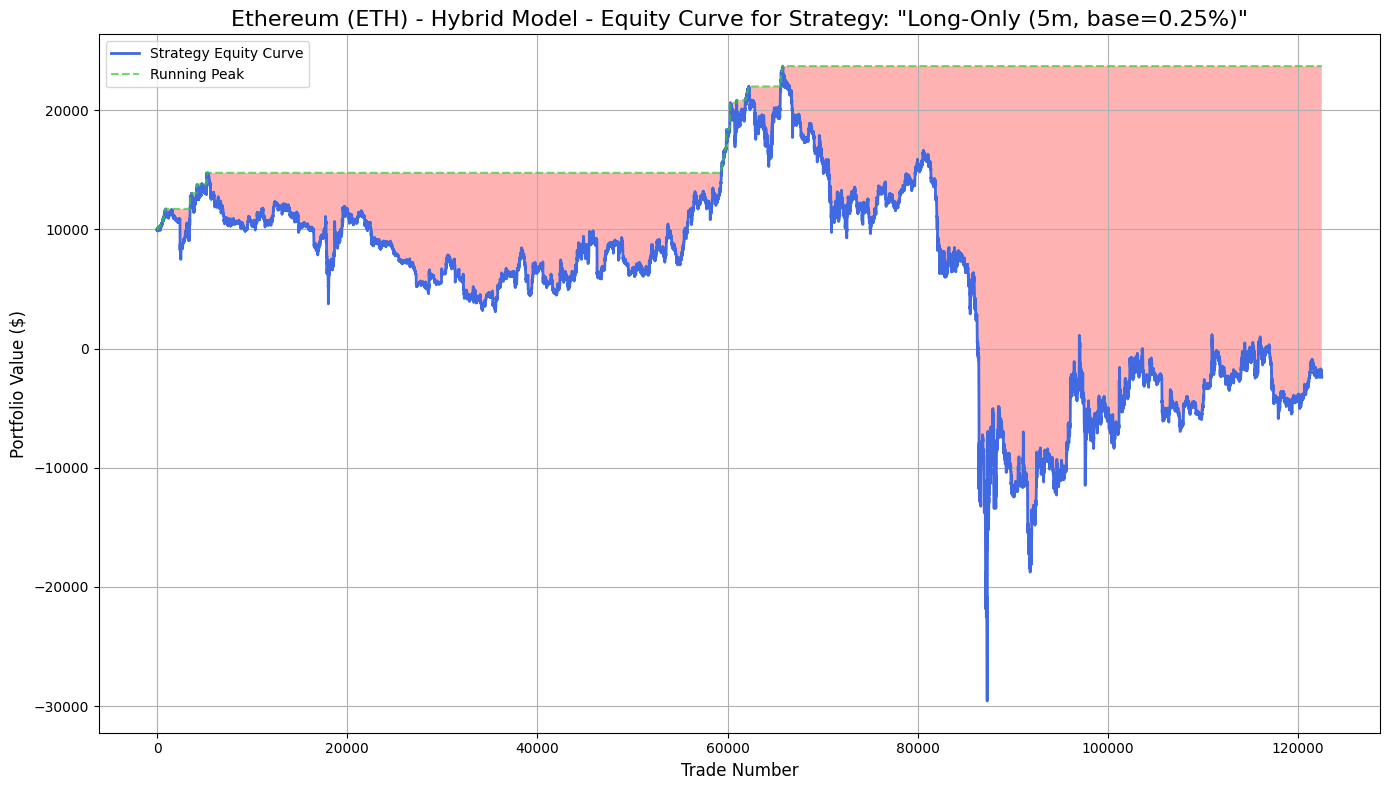


--- Running Backtest for Strategy: Long-Short (5m, base=0.25%) ---
Parameters: {'name': 'Long-Short (5m, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.0008680555555555555, 'holding_period': 5, 'prediction_target': 'Target_5m_Pct_Change'}
Simulating trades...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Only (5m, base=0.5%) ---
Parameters: {'name': 'Long-Only (5m, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.001736111111111111, 'holding_period': 5, 'prediction_target': 'Target_5m_Pct_Change'}
Simulating trades...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (5m, base=0.5%) ---
Parameters: {'name': 'Long-Short (5m, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.001736111111111111, 'holding_period': 5, 'prediction_target': 'Target_5m_Pct_Change'}
Simulating trades...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: L

C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\372157487.py:110: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


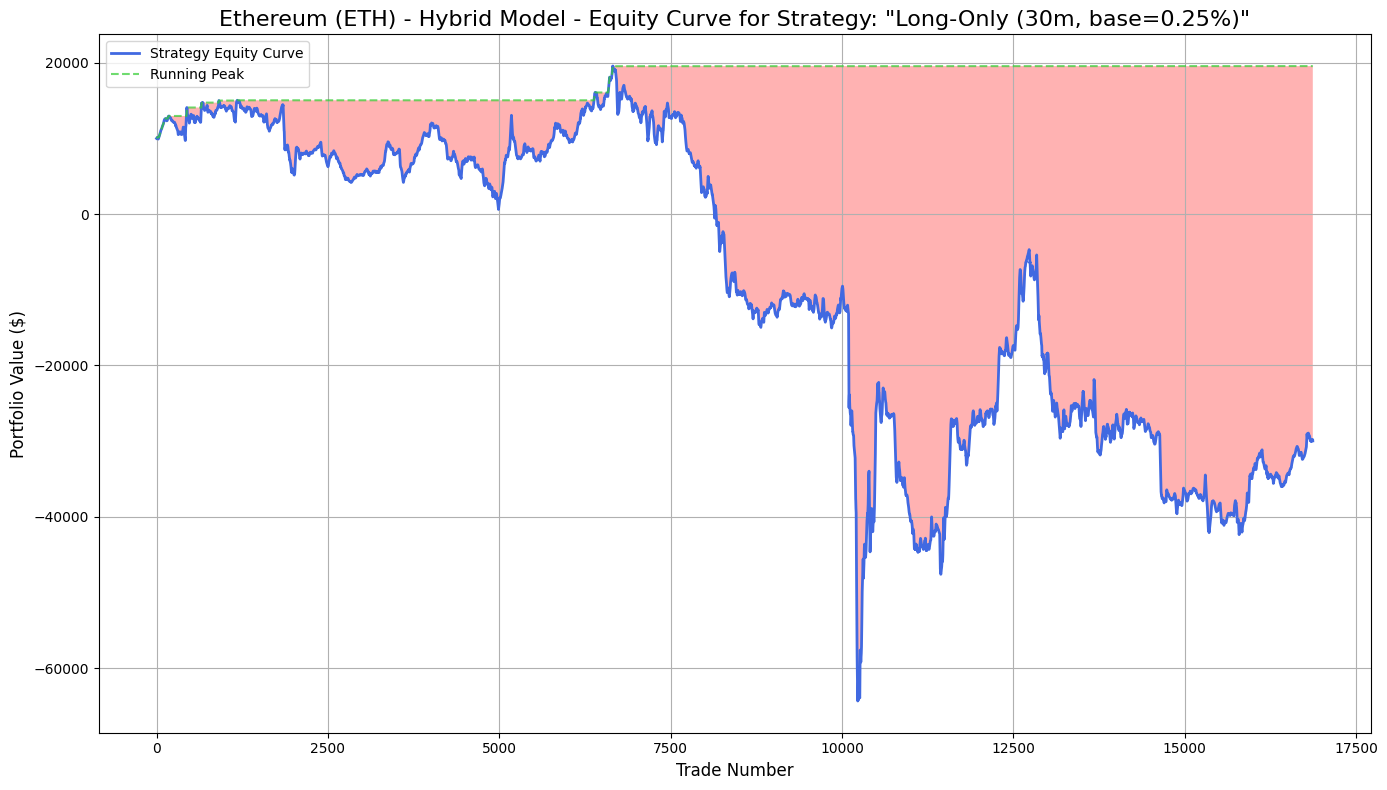


--- Running Backtest for Strategy: Long-Short (30m, base=0.25%) ---
Parameters: {'name': 'Long-Short (30m, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.005208333333333333, 'holding_period': 30, 'prediction_target': 'Target_30m_Pct_Change'}
Simulating trades...


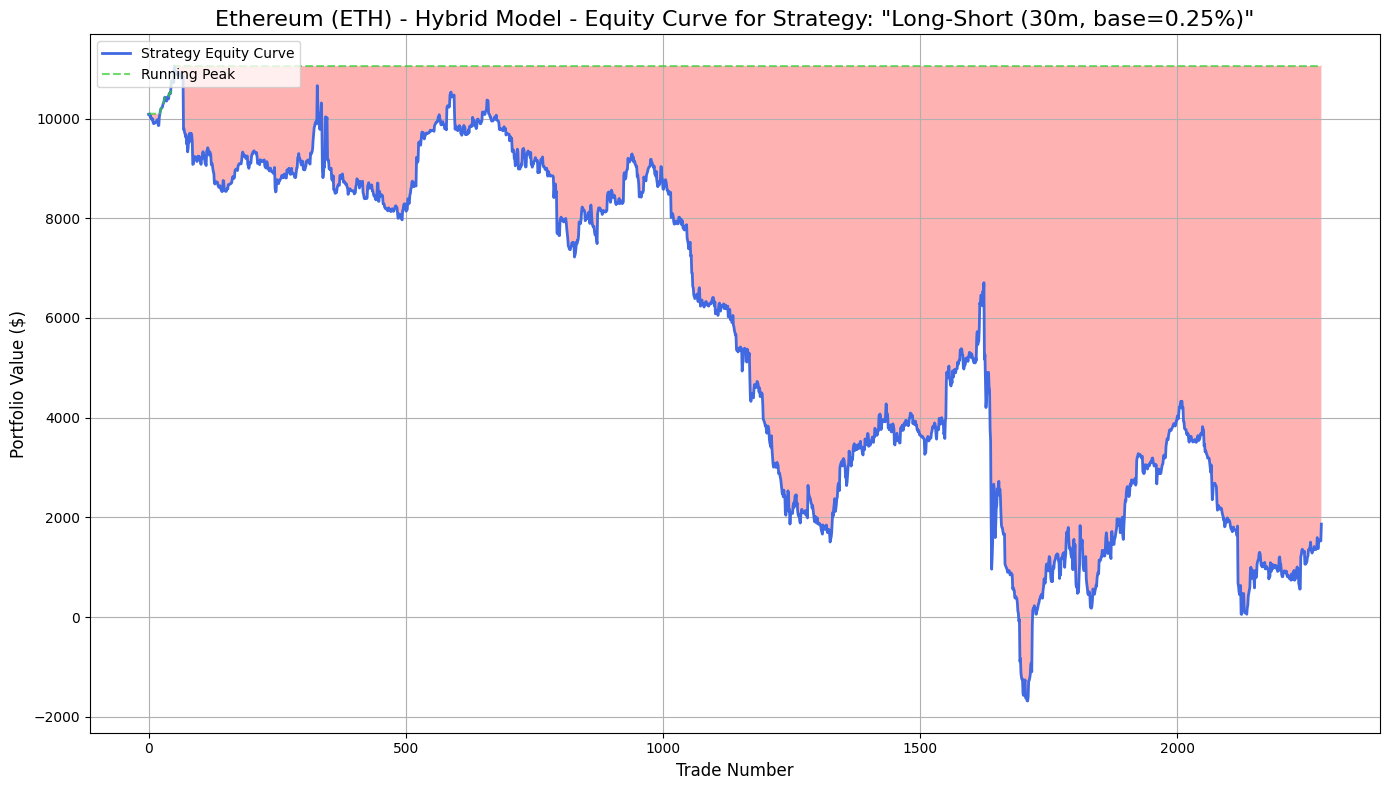


--- Running Backtest for Strategy: Long-Only (30m, base=0.5%) ---
Parameters: {'name': 'Long-Only (30m, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.010416666666666666, 'holding_period': 30, 'prediction_target': 'Target_30m_Pct_Change'}
Simulating trades...


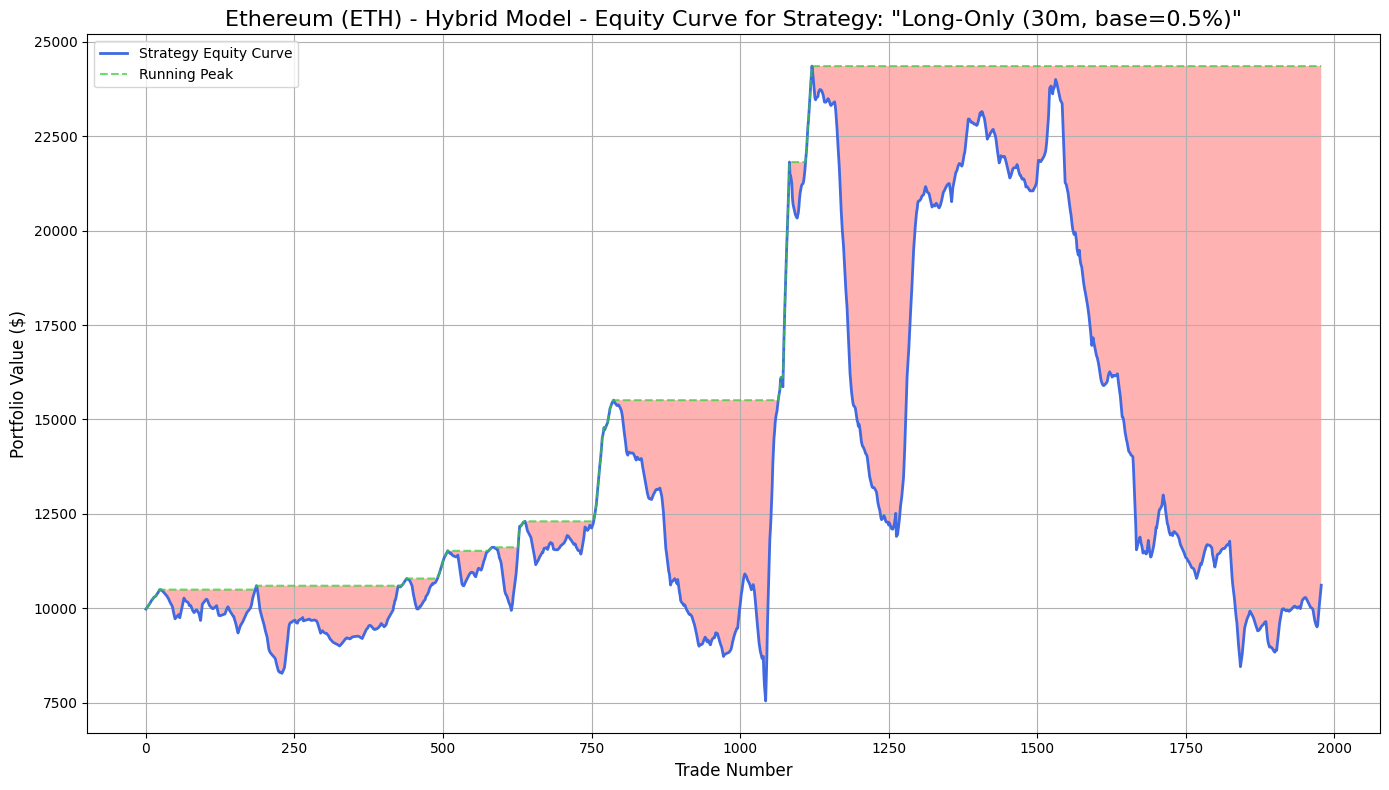


--- Running Backtest for Strategy: Long-Short (30m, base=0.5%) ---
Parameters: {'name': 'Long-Short (30m, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.010416666666666666, 'holding_period': 30, 'prediction_target': 'Target_30m_Pct_Change'}
Simulating trades...


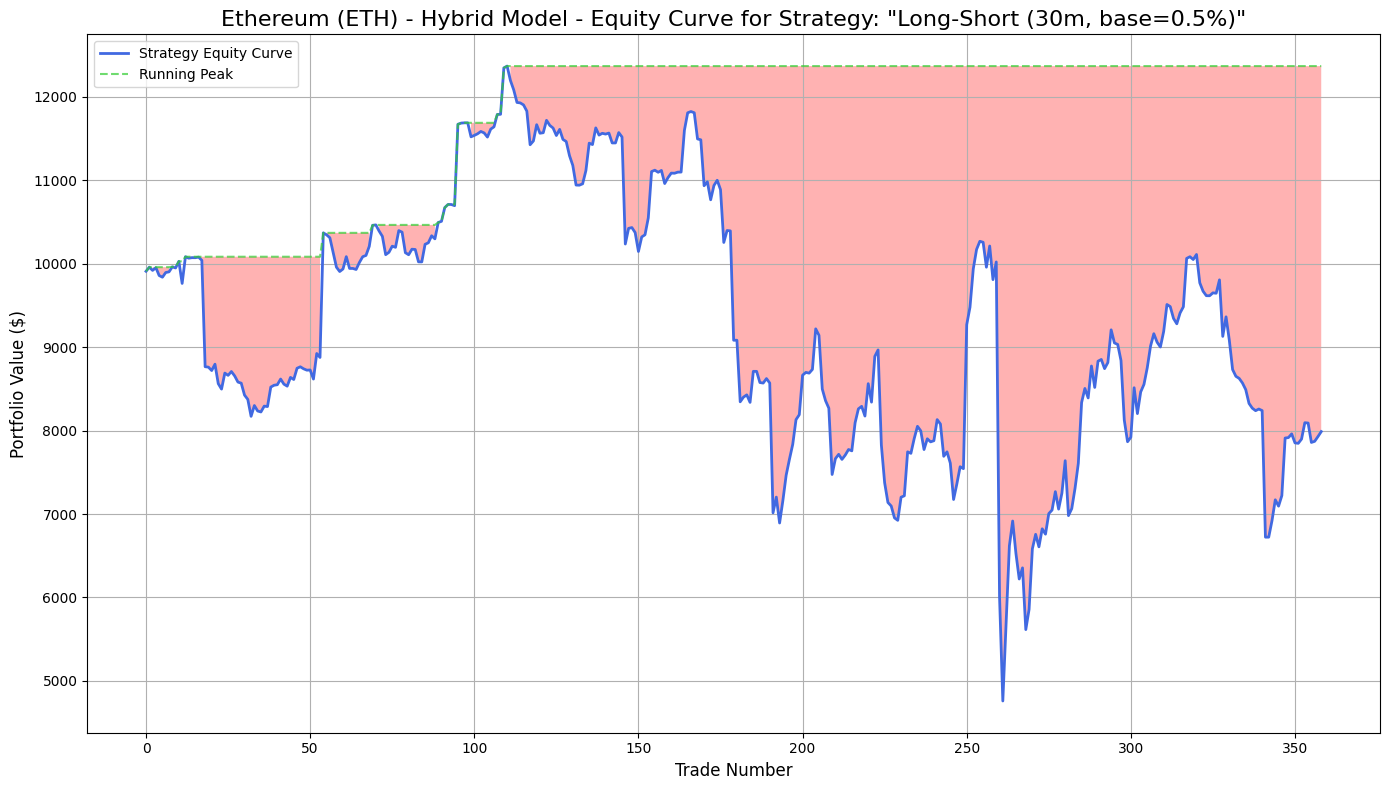


--- Running Backtest for Strategy: Long-Only (30m, base=1.0%) ---
Parameters: {'name': 'Long-Only (30m, base=1.0%)', 'type': 'long_only', 'trade_threshold': 0.020833333333333332, 'holding_period': 30, 'prediction_target': 'Target_30m_Pct_Change'}
Simulating trades...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (30m, base=1.0%) ---
Parameters: {'name': 'Long-Short (30m, base=1.0%)', 'type': 'long_short', 'trade_threshold': 0.020833333333333332, 'holding_period': 30, 'prediction_target': 'Target_30m_Pct_Change'}
Simulating trades...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Only (4h, base=0.25%) ---
Parameters: {'name': 'Long-Only (4h, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.041666666666666664, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\372157487.py:110: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


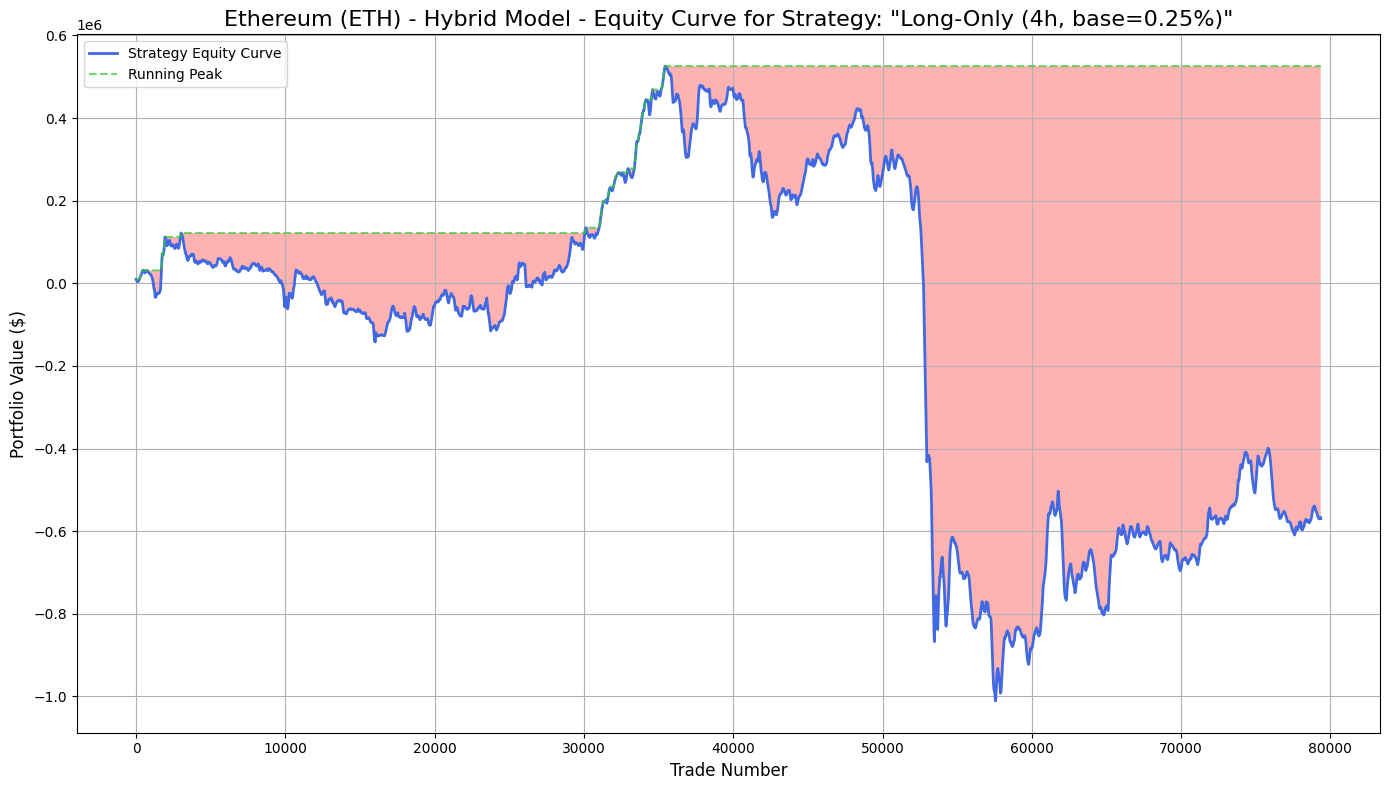


--- Running Backtest for Strategy: Long-Short (4h, base=0.25%) ---
Parameters: {'name': 'Long-Short (4h, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.041666666666666664, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades...


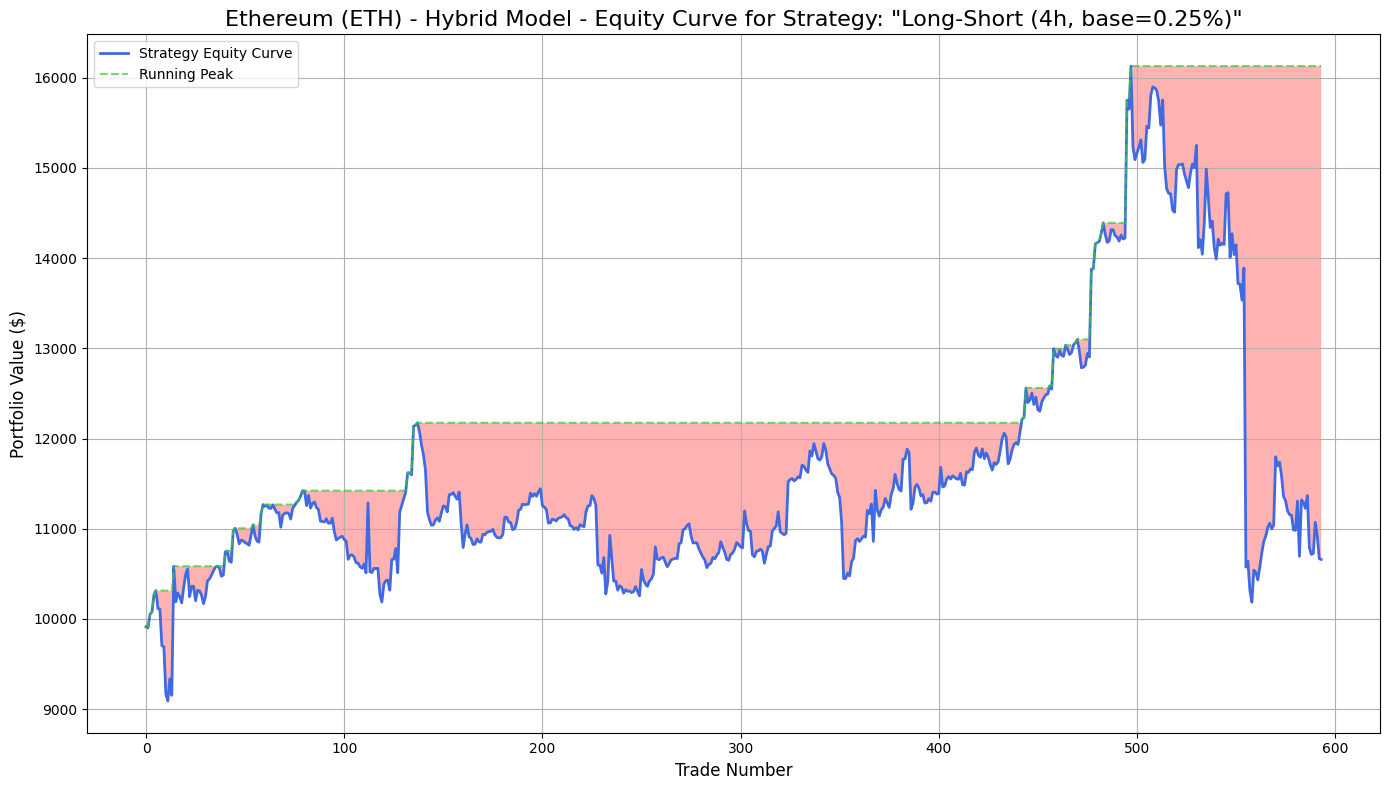


--- Running Backtest for Strategy: Long-Only (4h, base=0.5%) ---
Parameters: {'name': 'Long-Only (4h, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.08333333333333333, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\372157487.py:110: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


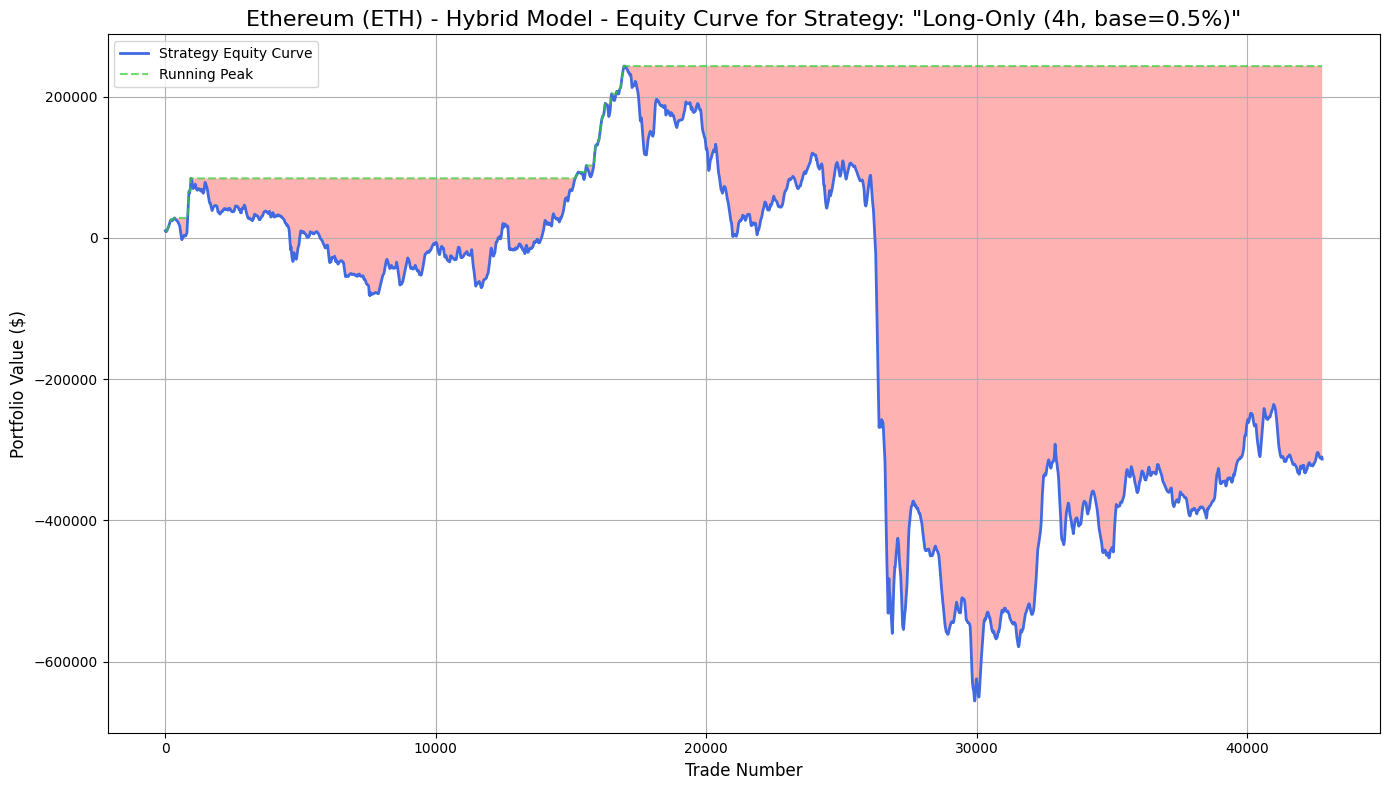


--- Running Backtest for Strategy: Long-Short (4h, base=0.5%) ---
Parameters: {'name': 'Long-Short (4h, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.08333333333333333, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Only (4h, base=1.0%) ---
Parameters: {'name': 'Long-Only (4h, base=1.0%)', 'type': 'long_only', 'trade_threshold': 0.16666666666666666, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\372157487.py:110: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


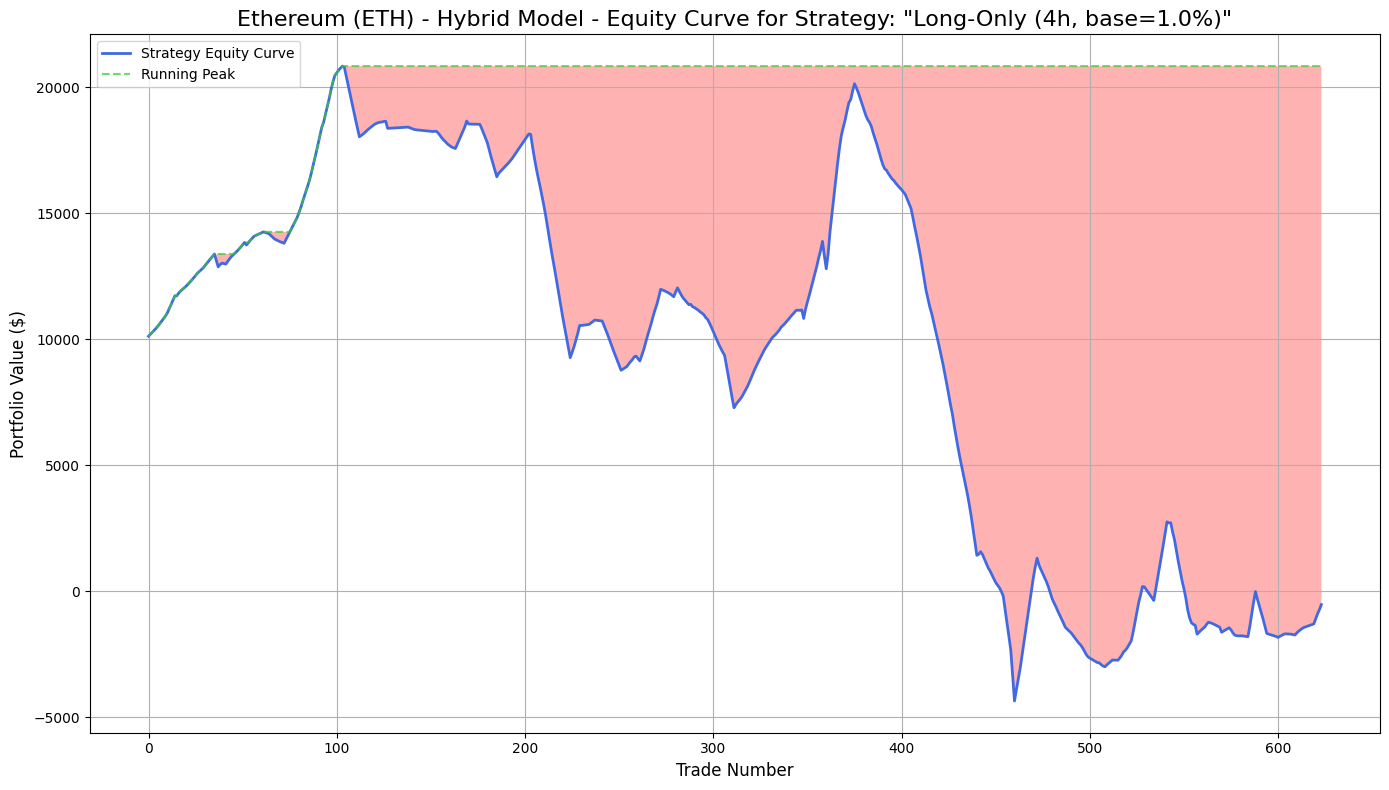


--- Running Backtest for Strategy: Long-Short (4h, base=1.0%) ---
Parameters: {'name': 'Long-Short (4h, base=1.0%)', 'type': 'long_short', 'trade_threshold': 0.16666666666666666, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Only (24h, base=0.25%) ---
Parameters: {'name': 'Long-Only (24h, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.25, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades...


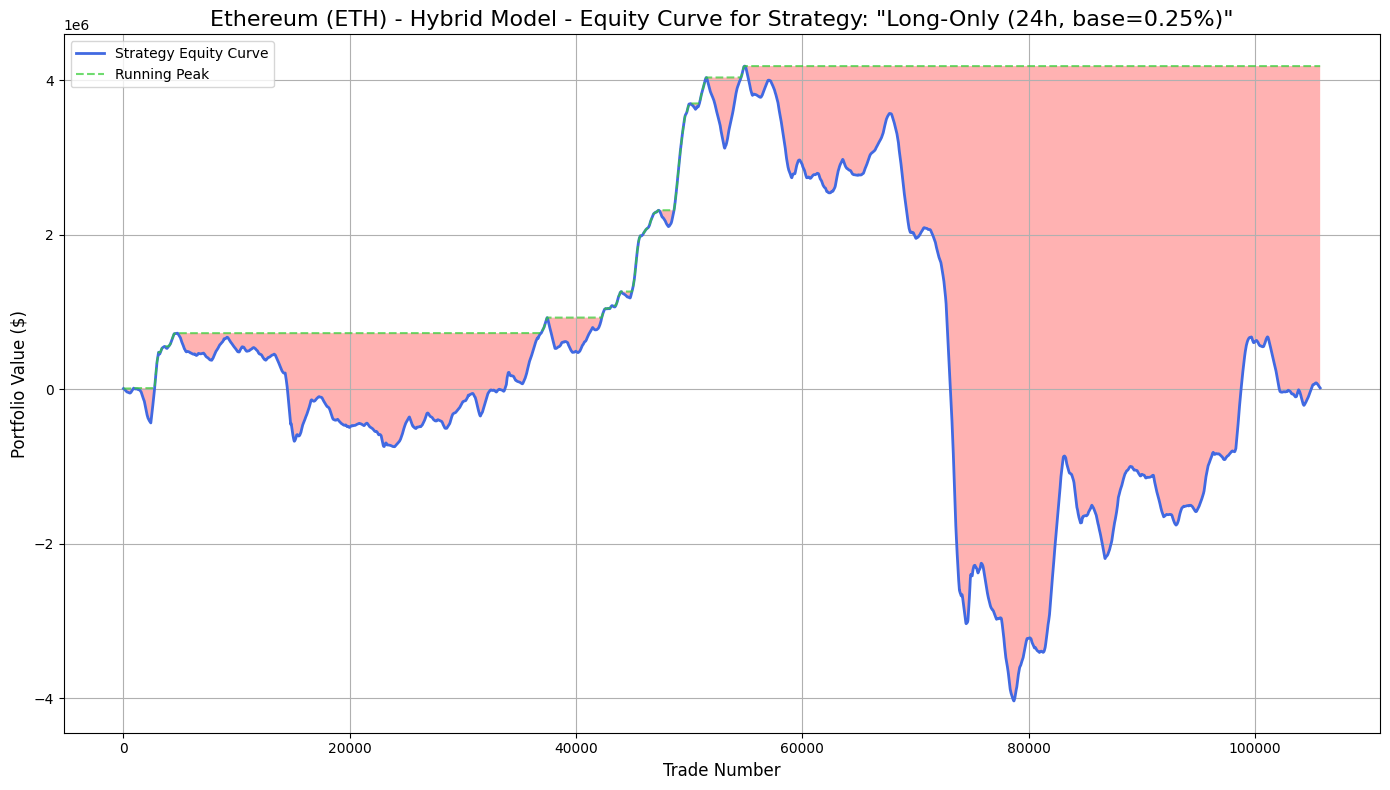


--- Running Backtest for Strategy: Long-Short (24h, base=0.25%) ---
Parameters: {'name': 'Long-Short (24h, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.25, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Only (24h, base=0.5%) ---
Parameters: {'name': 'Long-Only (24h, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.5, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\372157487.py:110: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


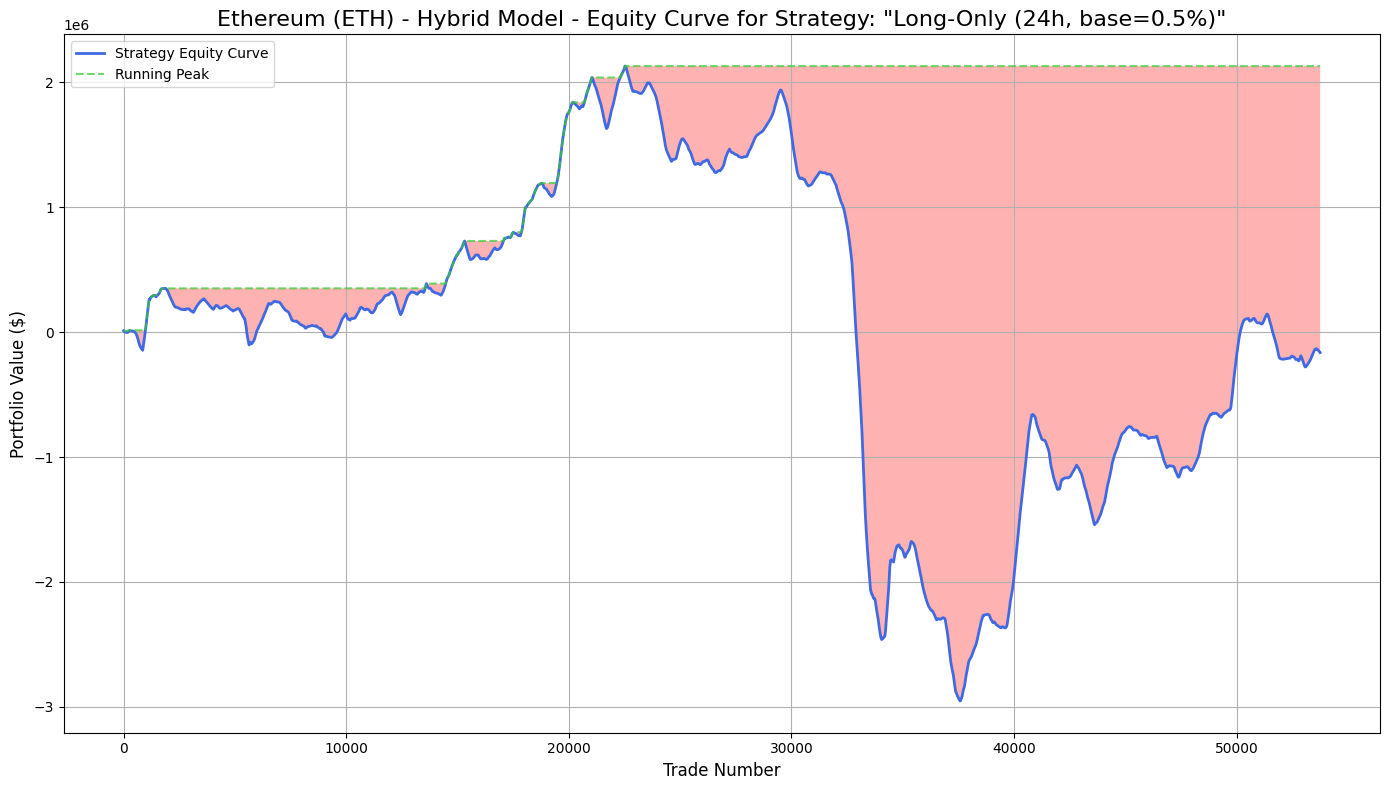


--- Running Backtest for Strategy: Long-Short (24h, base=0.5%) ---
Parameters: {'name': 'Long-Short (24h, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.5, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Only (24h, base=1.0%) ---
Parameters: {'name': 'Long-Only (24h, base=1.0%)', 'type': 'long_only', 'trade_threshold': 1.0, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (24h, base=1.0%) ---
Parameters: {'name': 'Long-Short (24h, base=1.0%)', 'type': 'long_short', 'trade_threshold': 1.0, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades...

--- No trades were triggered for this strategy. ---


--- MASTER STRATEGY COMPARISON (ETHEREUM) ---
                         

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- 1. Model Definition (Must match the trained model) ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out)
        out, _ = self.lstm2(out); out = self.dropout2(out)
        out = out[:, -1, :]; out = self.fc1(out)
        out = self.relu(out); out = self.fc2(out)
        return out

def run_backtest(asset_name, model_path, npz_path, raw_data_path, strategy_config):
    """
    A comprehensive backtesting function that simulates a given strategy and calculates advanced metrics.
    """
    strategy_name = strategy_config['name']
    print(f"\n{'='*30}\n--- Running Backtest for Strategy: {strategy_name} ---\n{'='*30}")
    print(f"Parameters: {strategy_config}")

    try:
        # --- Load Data & Model ---
        with np.load(npz_path, allow_pickle=True) as data:
            X_test, target_cols = data['X_test'], data['target_cols']
            X_test = X_test.astype(np.float32)

        raw_df = pd.read_csv(raw_data_path)
        # Handle Ethereum's specific format
        raw_df.rename(columns={'Unix Timestamp': 'Timestamp'}, inplace=True, errors='ignore')
        raw_df['Timestamp'] = pd.to_datetime(raw_df['Timestamp'] / 1000, unit='s')
        raw_df.sort_values('Timestamp', inplace=True)
        raw_df.reset_index(drop=True, inplace=True)
        
        required_len = len(X_test) + strategy_config['holding_period']
        test_prices_df = raw_df.tail(required_len).copy().reset_index(drop=True)
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = HybridLSTM(X_test.shape[2], 40, len(target_cols)).to(device)
        model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        model.eval()

        # --- Make Predictions ---
        test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=256)
        all_preds = [];
        with torch.no_grad():
            for batch_X_tuple in test_loader:
                preds = model(batch_X_tuple[0].to(device))
                all_preds.append(preds.cpu().numpy())
        predictions = np.concatenate(all_preds, axis=0)
            
        target_col_index = np.where(target_cols == strategy_config['prediction_target'])[0][0]
        final_predictions = predictions[:, target_col_index]

        # --- Simulate Trades ---
        print("Simulating trades...")
        trades = []
        if strategy_config['type'] == 'long_only':
            for i in range(len(final_predictions)):
                if i + strategy_config['holding_period'] >= len(test_prices_df): break
                if final_predictions[i] > strategy_config['trade_threshold']:
                    entry = test_prices_df['Close'].iloc[i]
                    exit_price = test_prices_df['Close'].iloc[i + strategy_config['holding_period']]
                    trades.append({"return_pct": ((exit_price - entry) / entry) * 100})
        elif strategy_config['type'] == 'long_short':
            position = "FLAT"; entry_price = 0
            for i in range(len(final_predictions)):
                if i + strategy_config['holding_period'] >= len(test_prices_df): break
                prediction = final_predictions[i]
                current_price = test_prices_df['Close'].iloc[i]
                if position == "FLAT":
                    if prediction > strategy_config['trade_threshold']: position = "LONG"; entry_price = current_price
                    elif prediction < -strategy_config['trade_threshold']: position = "SHORT"; entry_price = current_price
                elif position == "LONG" and prediction < -strategy_config['trade_threshold']:
                    pnl = ((current_price - entry_price) / entry_price) * 100; trades.append({"return_pct": pnl}); position = "FLAT"
                elif position == "SHORT" and prediction > strategy_config['trade_threshold']:
                    pnl = ((entry_price - current_price) / entry_price) * 100; trades.append({"return_pct": pnl}); position = "FLAT"

        if not trades: print("\n--- No trades were triggered for this strategy. ---"); return None

        # --- Calculate Metrics ---
        trades_df = pd.DataFrame(trades)
        total_trades = len(trades_df); winning_trades_df = trades_df[trades_df['return_pct'] > 0]; win_rate = len(winning_trades_df) / total_trades * 100
        avg_return_per_trade = trades_df['return_pct'].mean(); avg_profit_on_winners = winning_trades_df['return_pct'].mean()
        initial_capital = 10000; returns_series = trades_df['return_pct'] / 100; pnl_series = returns_series * initial_capital
        equity_curve = pnl_series.cumsum() + initial_capital; final_capital = equity_curve.iloc[-1]
        strategy_total_return = (final_capital - initial_capital) / initial_capital * 100
        days_in_test_period = (test_prices_df['Timestamp'].iloc[-1] - test_prices_df['Timestamp'].iloc[0]).days
        if returns_series.std() != 0 and days_in_test_period > 0 and total_trades > 0:
            sharpe_ratio = returns_series.mean() / returns_series.std()
            annualization_factor = np.sqrt(365 * 24 * 60 / (days_in_test_period * 24 * 60 / total_trades))
            annualized_sharpe = sharpe_ratio * annualization_factor
        else: annualized_sharpe = 0
        peak = equity_curve.expanding(min_periods=1).max(); drawdown = (equity_curve - peak) / peak
        max_drawdown_pct = drawdown.min() * -100 if not drawdown.empty else 0
        years_in_test = days_in_test_period / 365.25 if days_in_test_period > 0 else 1
        annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return
        calmar_ratio = annualized_return / max_drawdown_pct if max_drawdown_pct > 0 else 0
        buy_hold_return = (test_prices_df['Close'].iloc[-1] - test_prices_df['Close'].iloc[0]) / test_prices_df['Close'].iloc[0] * 100
        
        # --- Plotting ---
        fig, ax = plt.subplots(figsize=(14, 8)); ax.plot(equity_curve.index, equity_curve, label='Strategy Equity Curve', color='royalblue', linewidth=2)
        ax.plot(peak.index, peak, label='Running Peak', color='limegreen', linestyle='--', alpha=0.7); ax.fill_between(drawdown.index, equity_curve, peak, where=equity_curve < peak, facecolor='red', alpha=0.3)
        ax.set_title(f'{asset_name} - Equity Curve for Strategy: "{strategy_name}"', fontsize=16); ax.set_xlabel('Trade Number', fontsize=12); ax.set_ylabel('Portfolio Value ($)', fontsize=12)
        ax.legend(loc='upper left'); ax.grid(True); plt.tight_layout(); plt.show()
        
        return {"Strategy": strategy_name, "Total Return (%)": strategy_total_return, "Buy & Hold (%)": buy_hold_return, "Sharpe Ratio": annualized_sharpe, "Calmar Ratio": calmar_ratio, "Max Drawdown (%)": max_drawdown_pct, "Win Rate (%)": win_rate, "Total Trades": total_trades}

    except Exception as e:
        print(f"An error occurred during backtest for '{strategy_name}': {e}")
        return None

def main():
    # --- Master Configuration for Ethereum ---
    master_config = {
        "asset_name": "Ethereum (ETH) - Hybrid Model",
        "model_path": "ethereum_hybrid_pytorch_model.pth",
        "npz_path": "ethereum_hybrid_pytorch_data.npz",
        "raw_data_path": "E:\\BAMD\\Ethereum\\ETH_1min.csv", # <-- IMPORTANT: Use your FULL raw ETH file
    }

    horizons = {
        "5m": {"holding_period": 5, "target_col": "Target_5m_Pct_Change"},
        "30m": {"holding_period": 30, "target_col": "Target_30m_Pct_Change"},
        "4h": {"holding_period": 240, "target_col": "Target_4h_Pct_Change"},
        "24h": {"holding_period": 1440, "target_col": "Target_24h_Pct_Change"},
    }
    base_thresholds = [0.25, 0.5, 1.0]
    strategy_types = ["long_only", "long_short"]

    all_strategies = []
    # --- Programmatically Generate All 24 Strategies ---
    for horizon_name, horizon_props in horizons.items():
        for base_thresh in base_thresholds:
            minutes_in_horizon = horizon_props["holding_period"]
            scaled_threshold = base_thresh * (minutes_in_horizon / 1440.0)

            for strat_type in strategy_types:
                strategy_name_human = f"{strat_type.replace('_','-').title()} ({horizon_name}, base={base_thresh}%)"
                all_strategies.append({
                    "name": strategy_name_human,
                    "type": strat_type,
                    "trade_threshold": scaled_threshold,
                    "holding_period": horizon_props["holding_period"],
                    "prediction_target": horizon_props["target_col"],
                })

    summary_results = []
    for strategy_config in all_strategies:
        result = run_backtest(**master_config, strategy_config=strategy_config)
        if result:
            summary_results.append(result)
    
    if summary_results:
        print("\n\n" + "="*40)
        print("--- MASTER STRATEGY COMPARISON (ETHEREUM) ---")
        print("="*40)
        summary_df = pd.DataFrame(summary_results).set_index("Strategy")
        pd.options.display.float_format = '{:,.2f}'.format
        print(summary_df)

if __name__ == "__main__":
    main()


--- Running Backtest for Strategy: Long-Only (5m, base=0.25%) ---
Parameters: {'name': 'Long-Only (5m, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.0008680555555555555, 'holding_period': 5, 'prediction_target': 'Target_5m_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\239358030.py:103: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


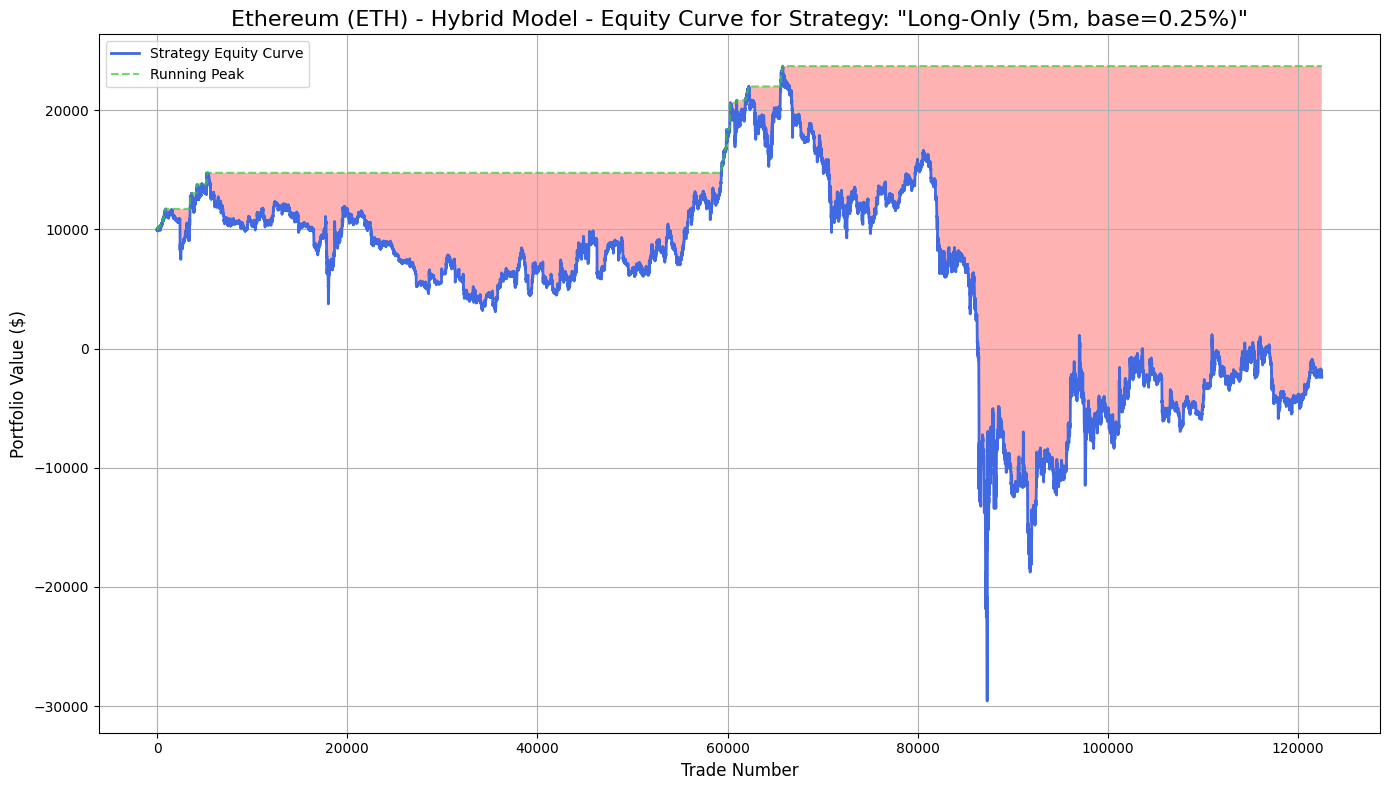


--- Running Backtest for Strategy: Long-Short (5m, base=0.25%) ---
Parameters: {'name': 'Long-Short (5m, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.0008680555555555555, 'holding_period': 5, 'prediction_target': 'Target_5m_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\239358030.py:103: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


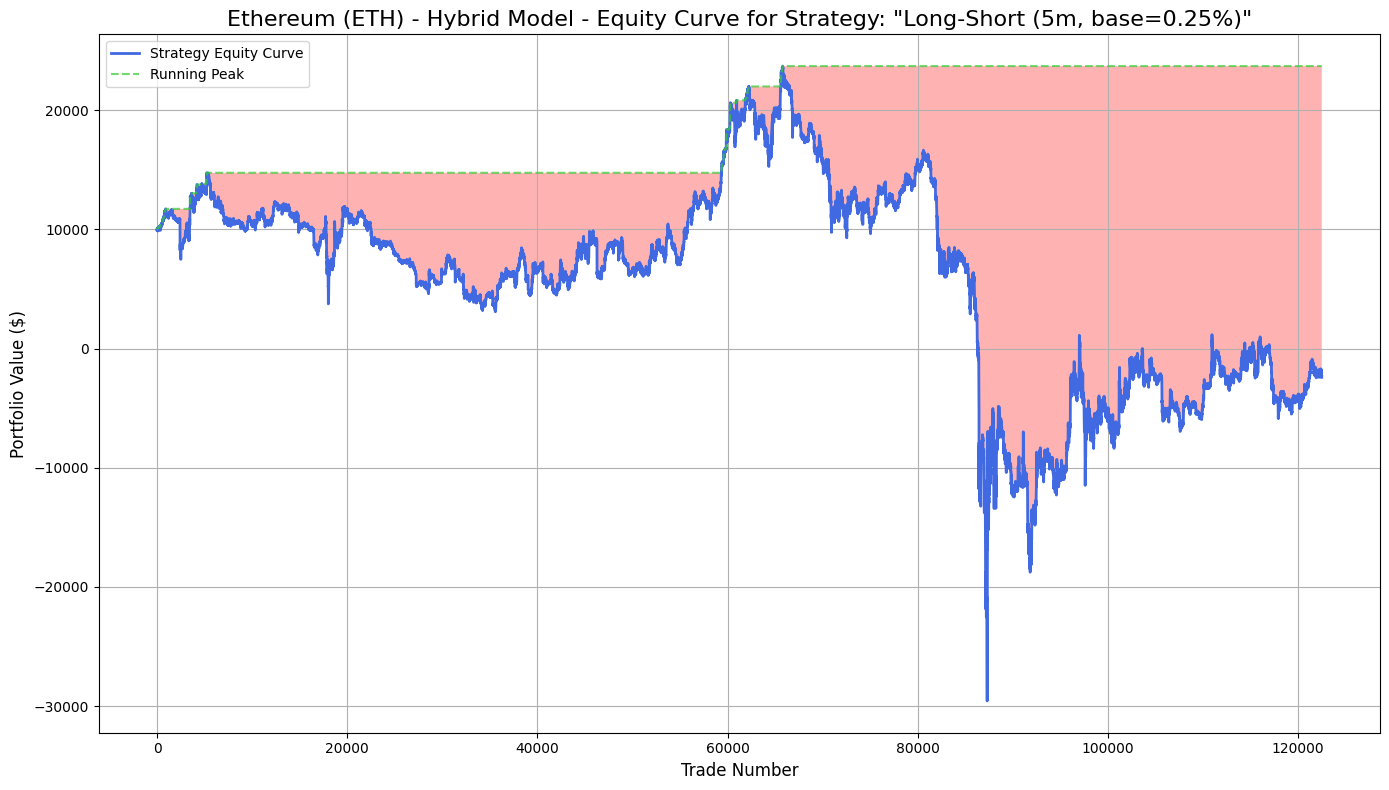


--- Running Backtest for Strategy: Long-Only (5m, base=0.5%) ---
Parameters: {'name': 'Long-Only (5m, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.001736111111111111, 'holding_period': 5, 'prediction_target': 'Target_5m_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (5m, base=0.5%) ---
Parameters: {'name': 'Long-Short (5m, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.001736111111111111, 'holding_period': 5, 'prediction_target': 'Target_5m_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Only (5m, base=1.0%) ---
Parameters: {'name': 'Long-Only (5m, base=1.0%)', 'type': 'long_only', 'trade_threshold': 0.003472222222222222, 'holding_period': 5, 'prediction_target': 'Target_5m_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades wer

C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\239358030.py:103: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


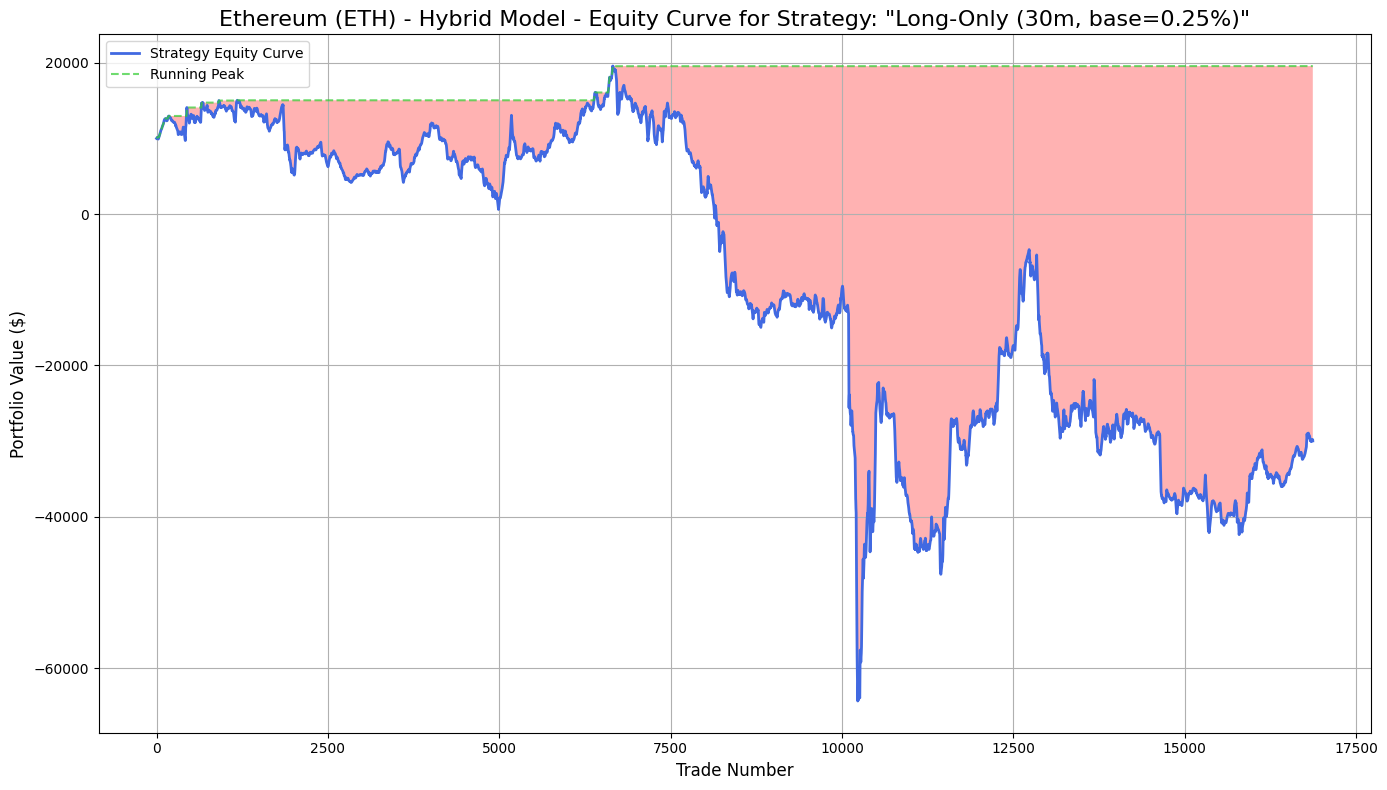


--- Running Backtest for Strategy: Long-Short (30m, base=0.25%) ---
Parameters: {'name': 'Long-Short (30m, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.005208333333333333, 'holding_period': 30, 'prediction_target': 'Target_30m_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\239358030.py:103: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


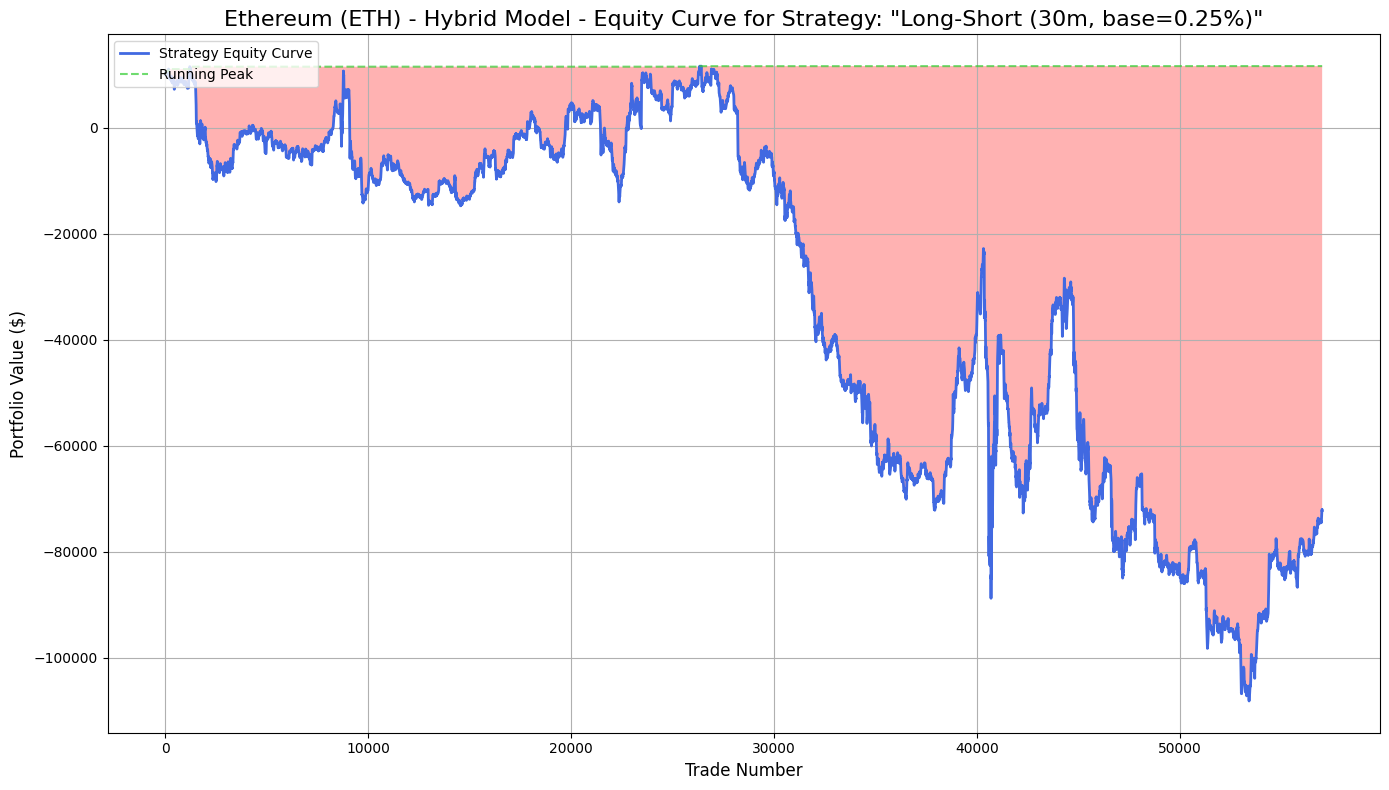


--- Running Backtest for Strategy: Long-Only (30m, base=0.5%) ---
Parameters: {'name': 'Long-Only (30m, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.010416666666666666, 'holding_period': 30, 'prediction_target': 'Target_30m_Pct_Change'}
Simulating trades with fixed holding period...


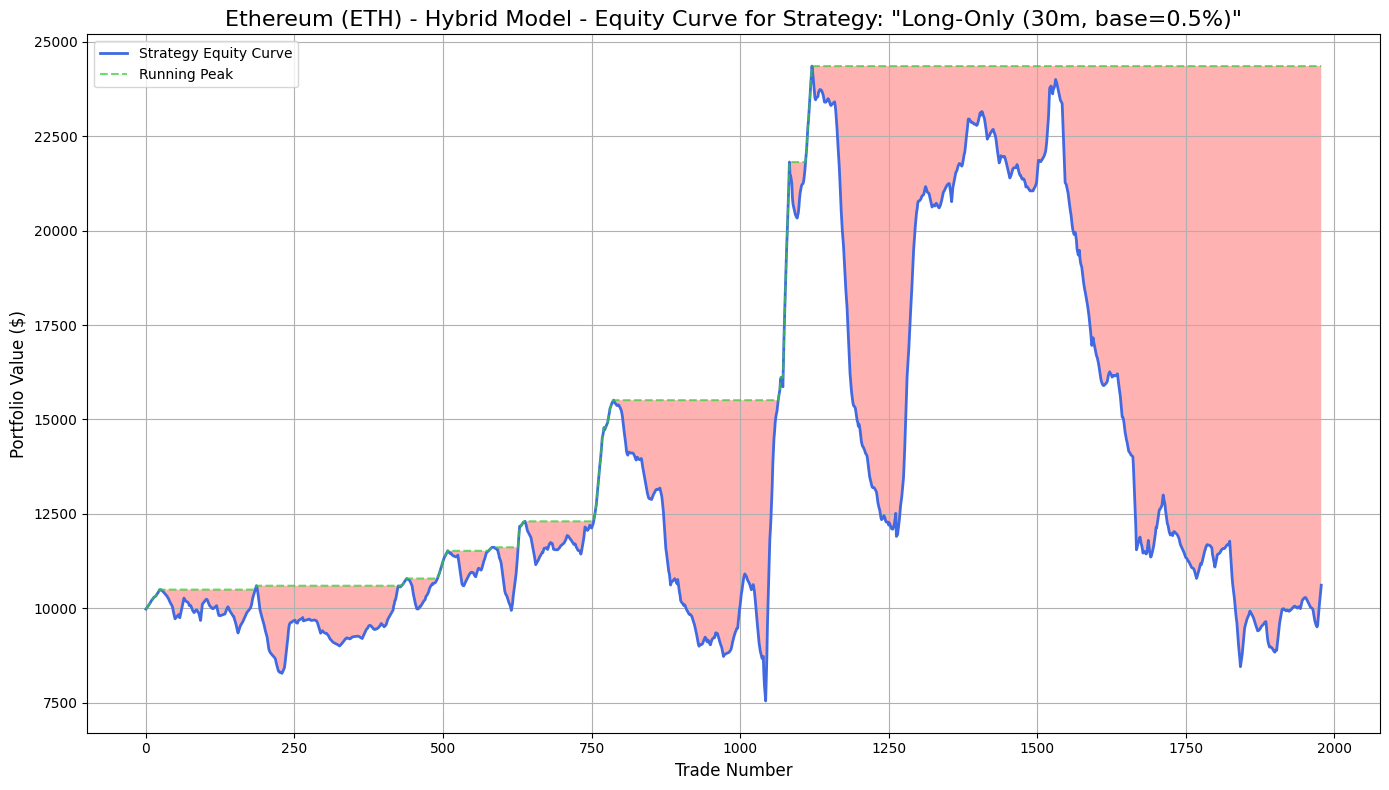


--- Running Backtest for Strategy: Long-Short (30m, base=0.5%) ---
Parameters: {'name': 'Long-Short (30m, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.010416666666666666, 'holding_period': 30, 'prediction_target': 'Target_30m_Pct_Change'}
Simulating trades with fixed holding period...


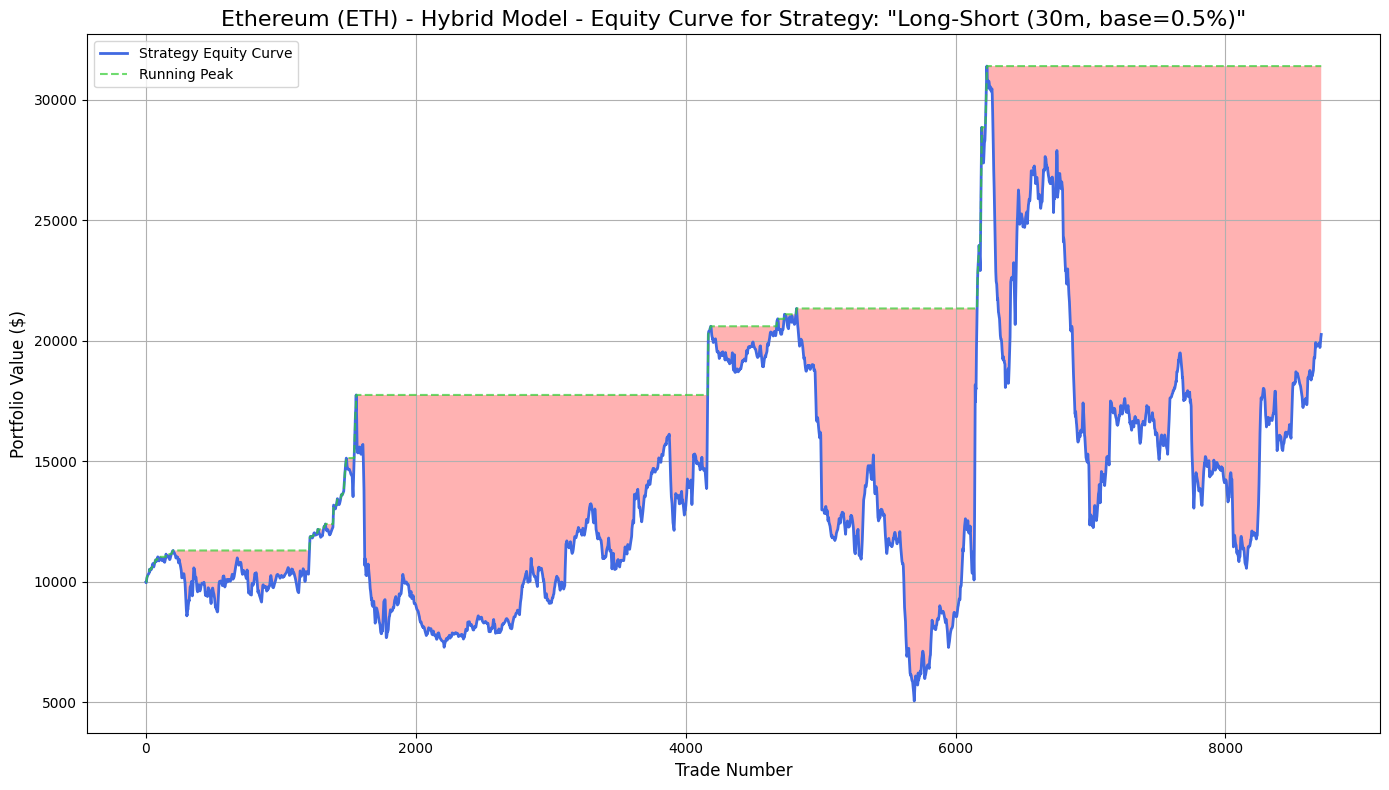


--- Running Backtest for Strategy: Long-Only (30m, base=1.0%) ---
Parameters: {'name': 'Long-Only (30m, base=1.0%)', 'type': 'long_only', 'trade_threshold': 0.020833333333333332, 'holding_period': 30, 'prediction_target': 'Target_30m_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (30m, base=1.0%) ---
Parameters: {'name': 'Long-Short (30m, base=1.0%)', 'type': 'long_short', 'trade_threshold': 0.020833333333333332, 'holding_period': 30, 'prediction_target': 'Target_30m_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Only (4h, base=0.25%) ---
Parameters: {'name': 'Long-Only (4h, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.041666666666666664, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\239358030.py:103: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


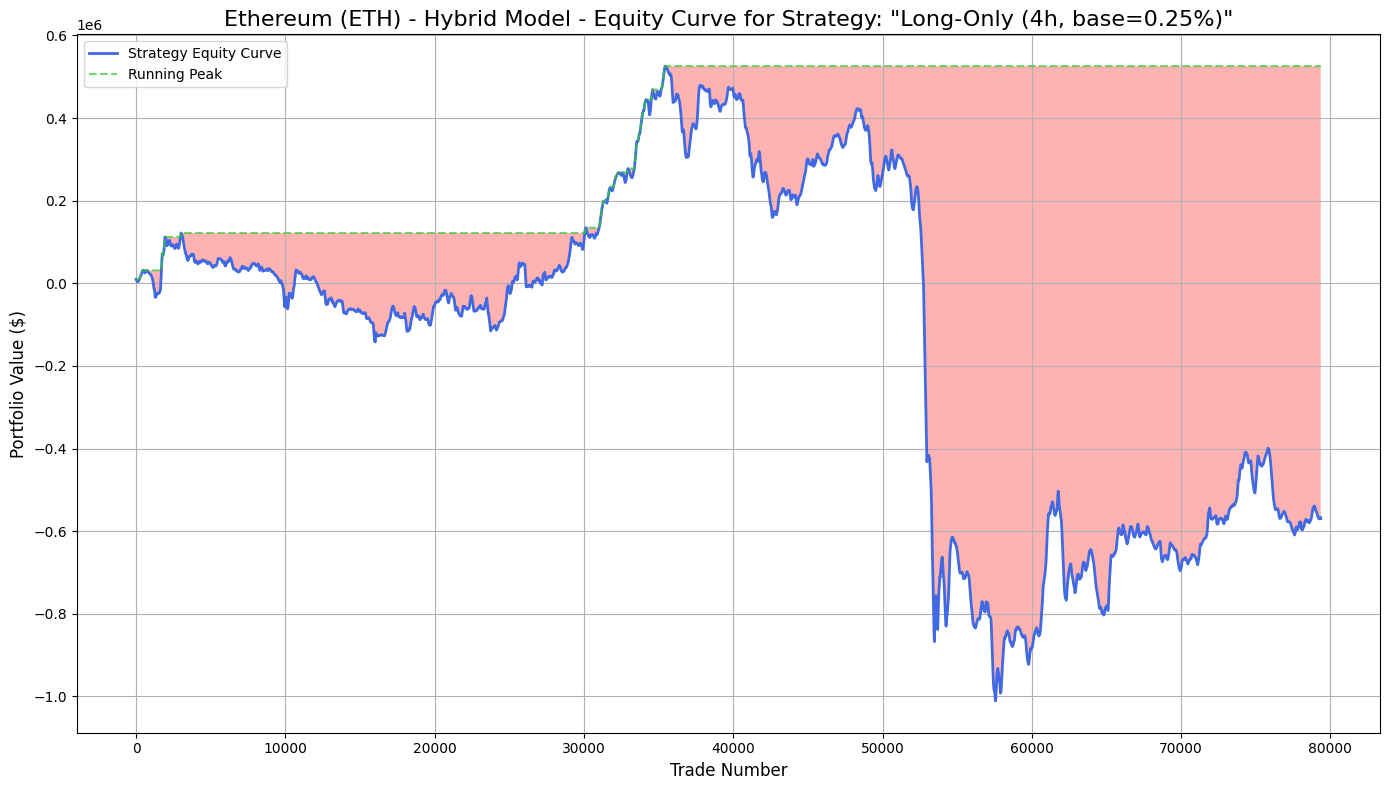


--- Running Backtest for Strategy: Long-Short (4h, base=0.25%) ---
Parameters: {'name': 'Long-Short (4h, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.041666666666666664, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\239358030.py:103: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


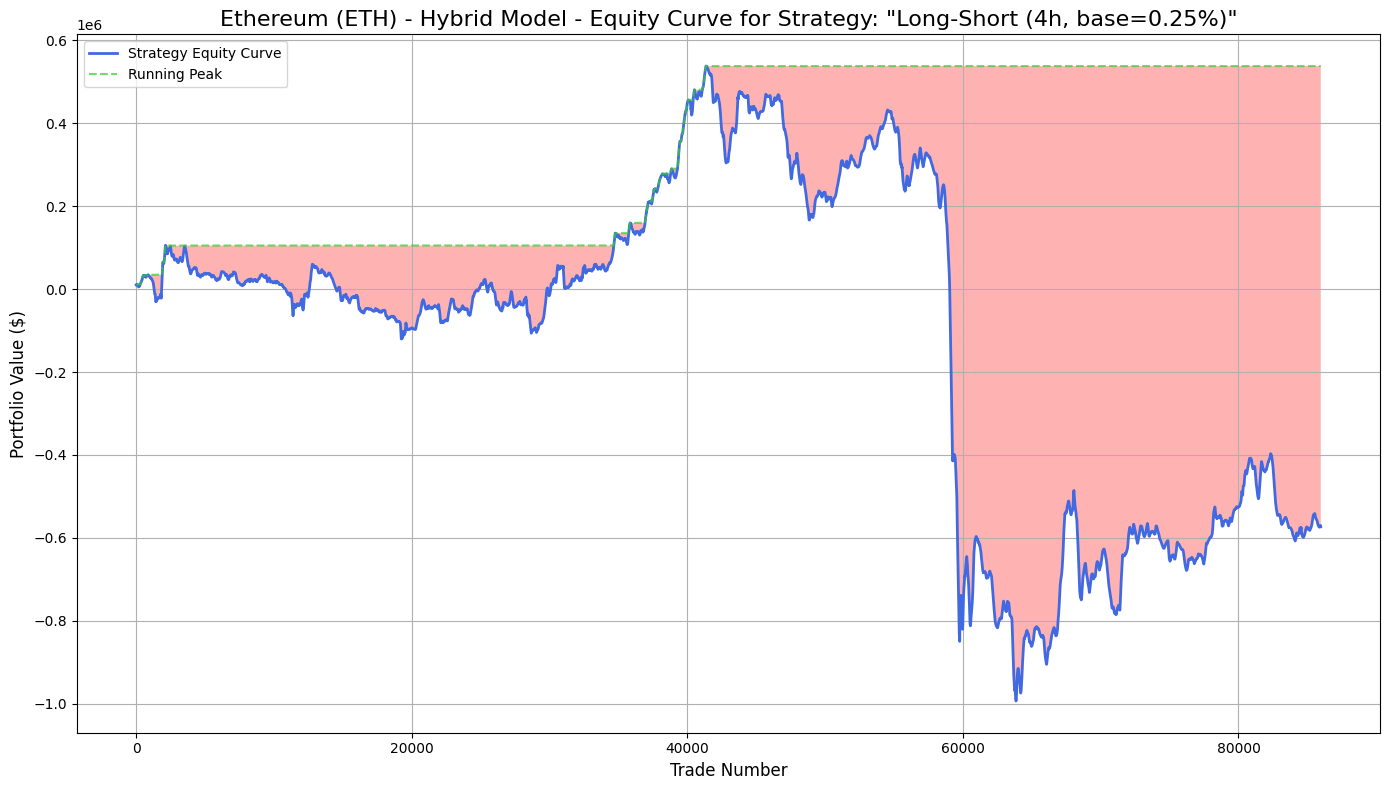


--- Running Backtest for Strategy: Long-Only (4h, base=0.5%) ---
Parameters: {'name': 'Long-Only (4h, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.08333333333333333, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\239358030.py:103: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


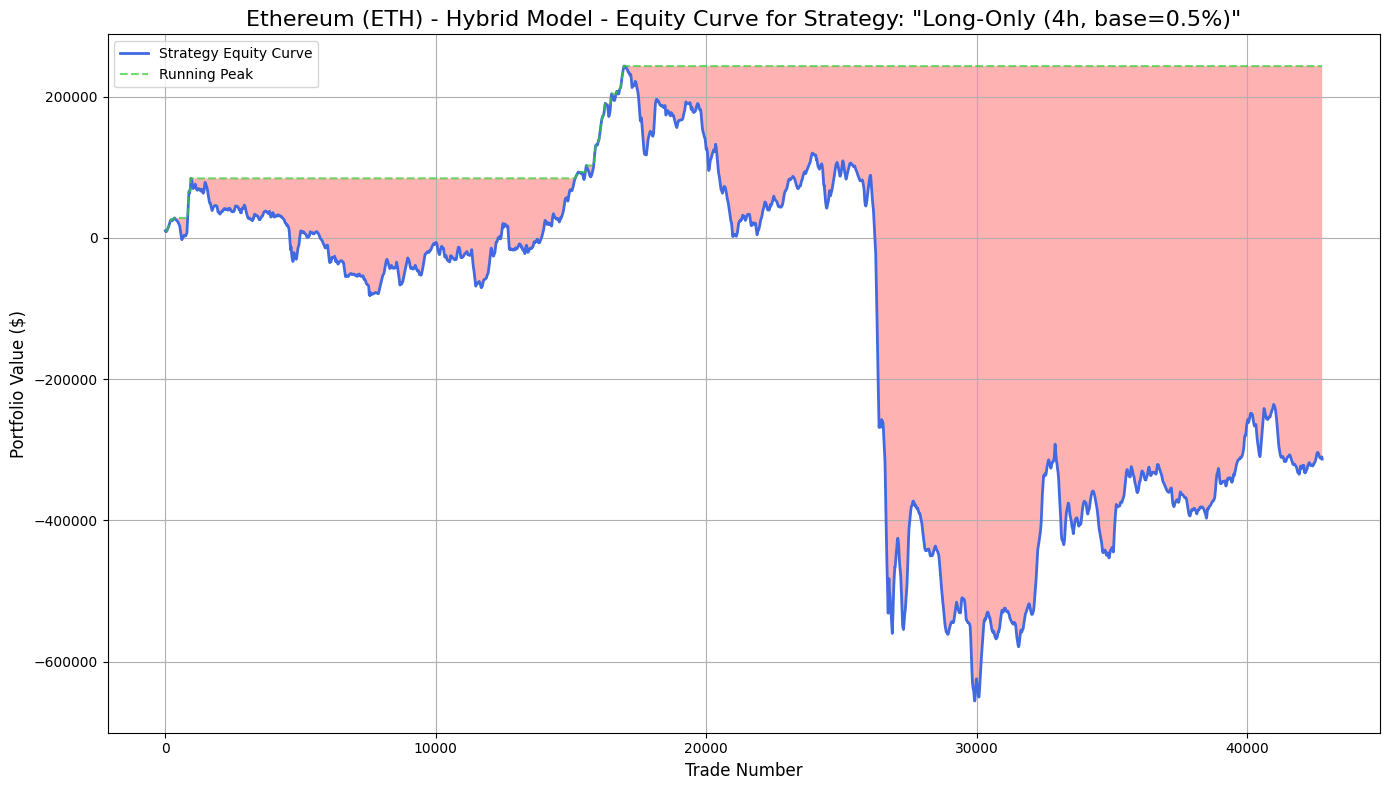


--- Running Backtest for Strategy: Long-Short (4h, base=0.5%) ---
Parameters: {'name': 'Long-Short (4h, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.08333333333333333, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\239358030.py:103: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


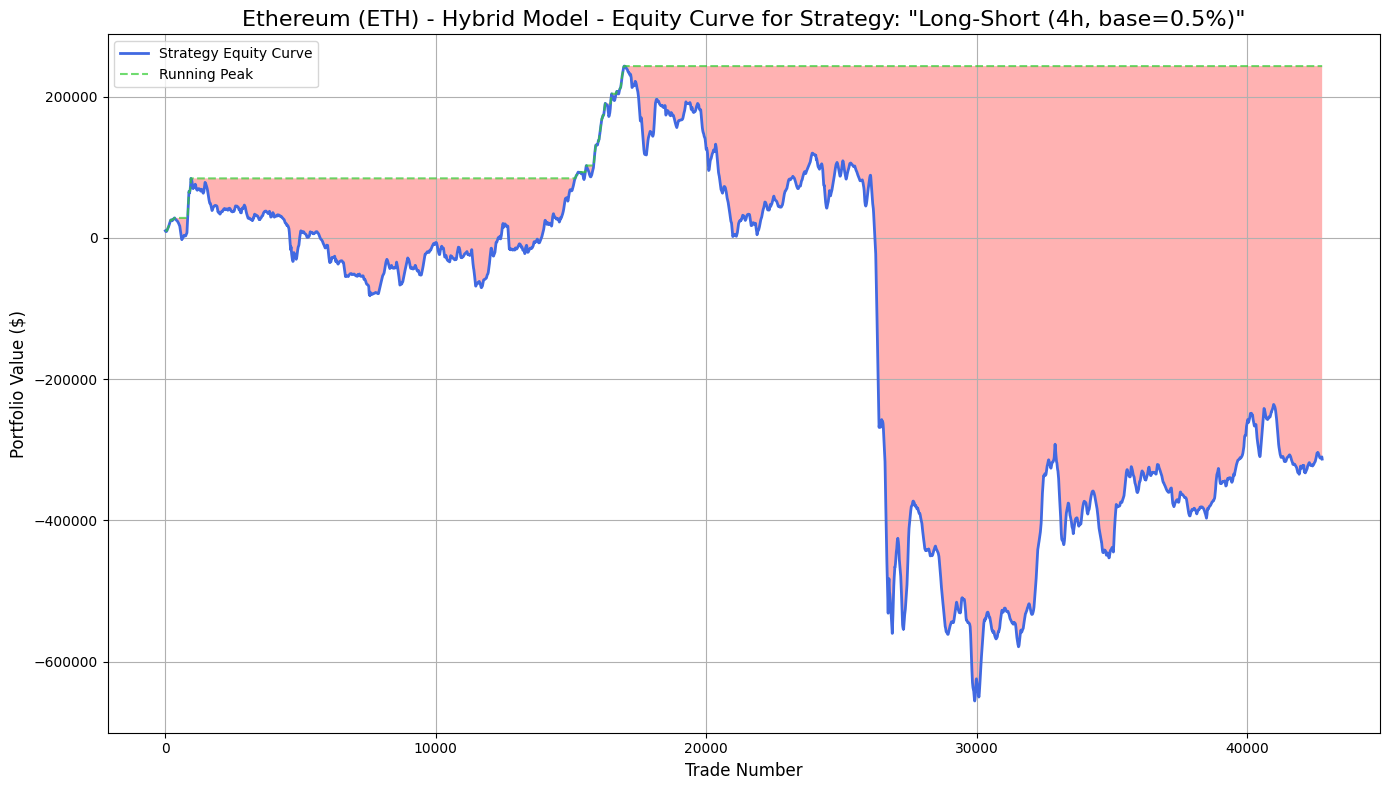


--- Running Backtest for Strategy: Long-Only (4h, base=1.0%) ---
Parameters: {'name': 'Long-Only (4h, base=1.0%)', 'type': 'long_only', 'trade_threshold': 0.16666666666666666, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\239358030.py:103: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


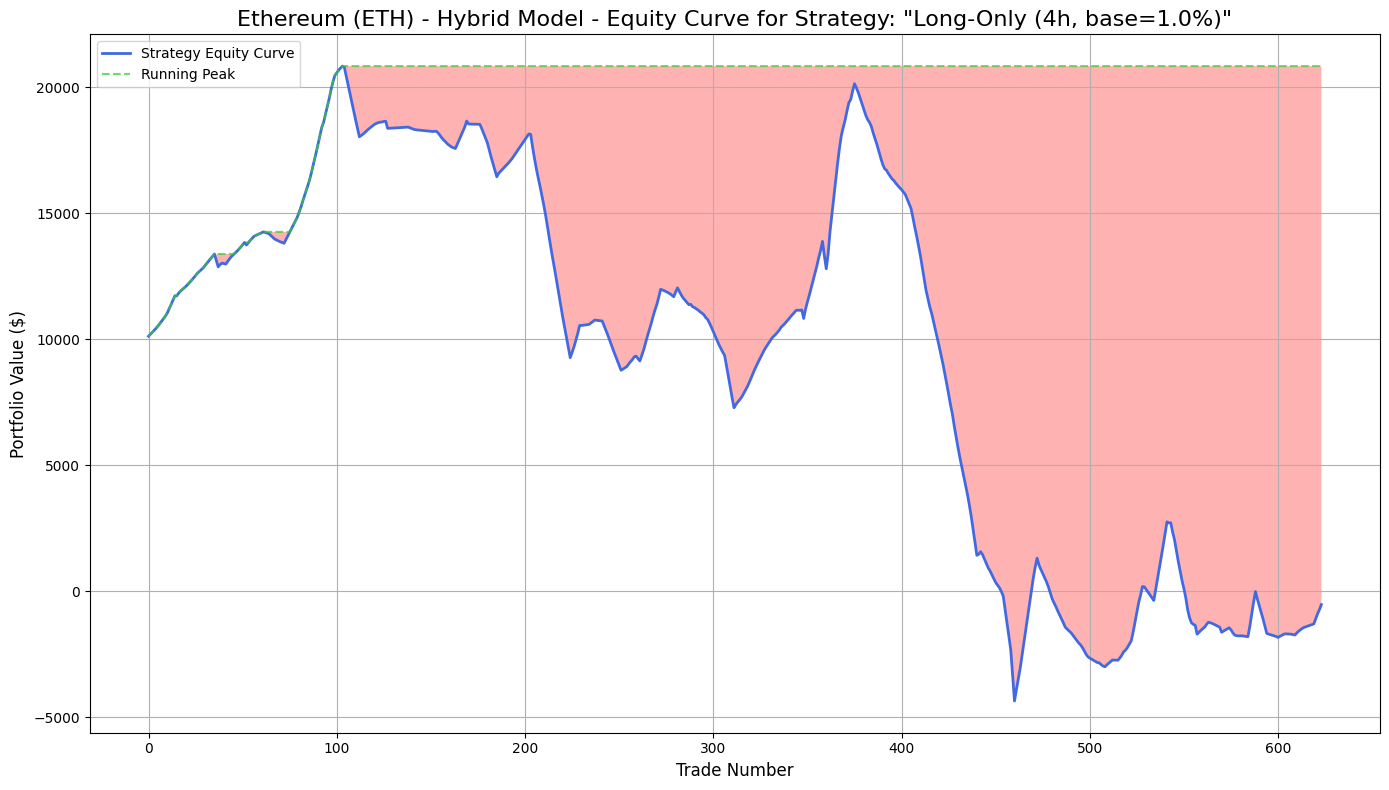


--- Running Backtest for Strategy: Long-Short (4h, base=1.0%) ---
Parameters: {'name': 'Long-Short (4h, base=1.0%)', 'type': 'long_short', 'trade_threshold': 0.16666666666666666, 'holding_period': 240, 'prediction_target': 'Target_4h_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\239358030.py:103: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


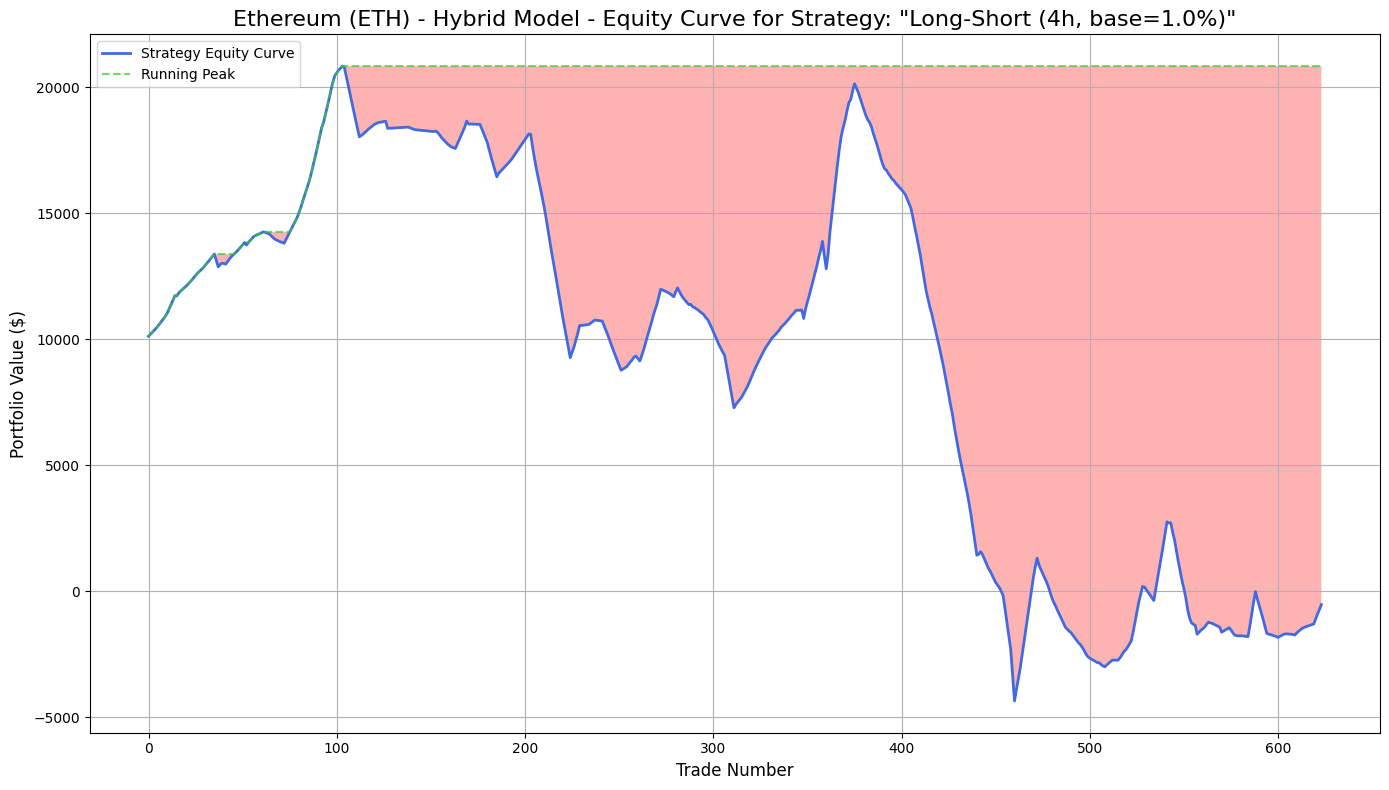


--- Running Backtest for Strategy: Long-Only (24h, base=0.25%) ---
Parameters: {'name': 'Long-Only (24h, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.25, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades with fixed holding period...


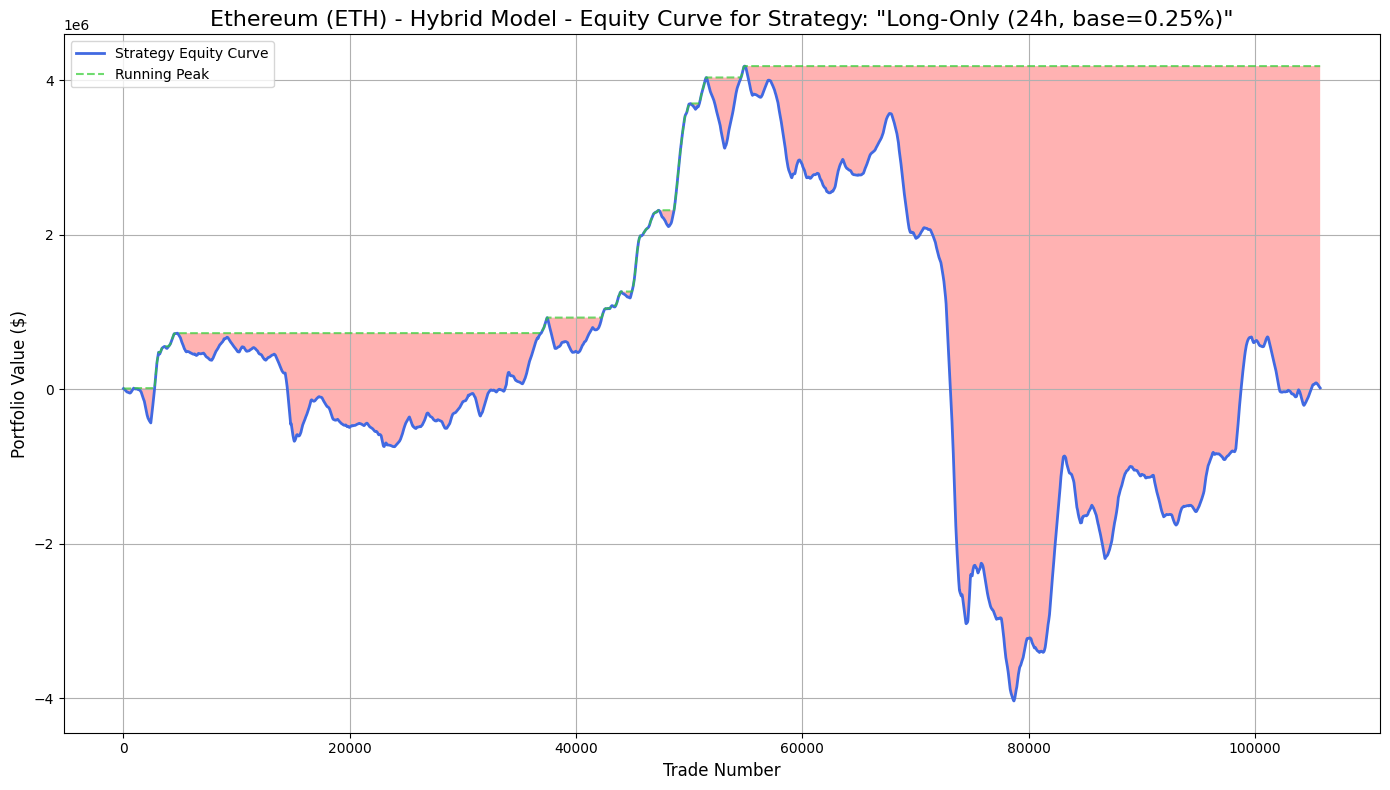


--- Running Backtest for Strategy: Long-Short (24h, base=0.25%) ---
Parameters: {'name': 'Long-Short (24h, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.25, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades with fixed holding period...


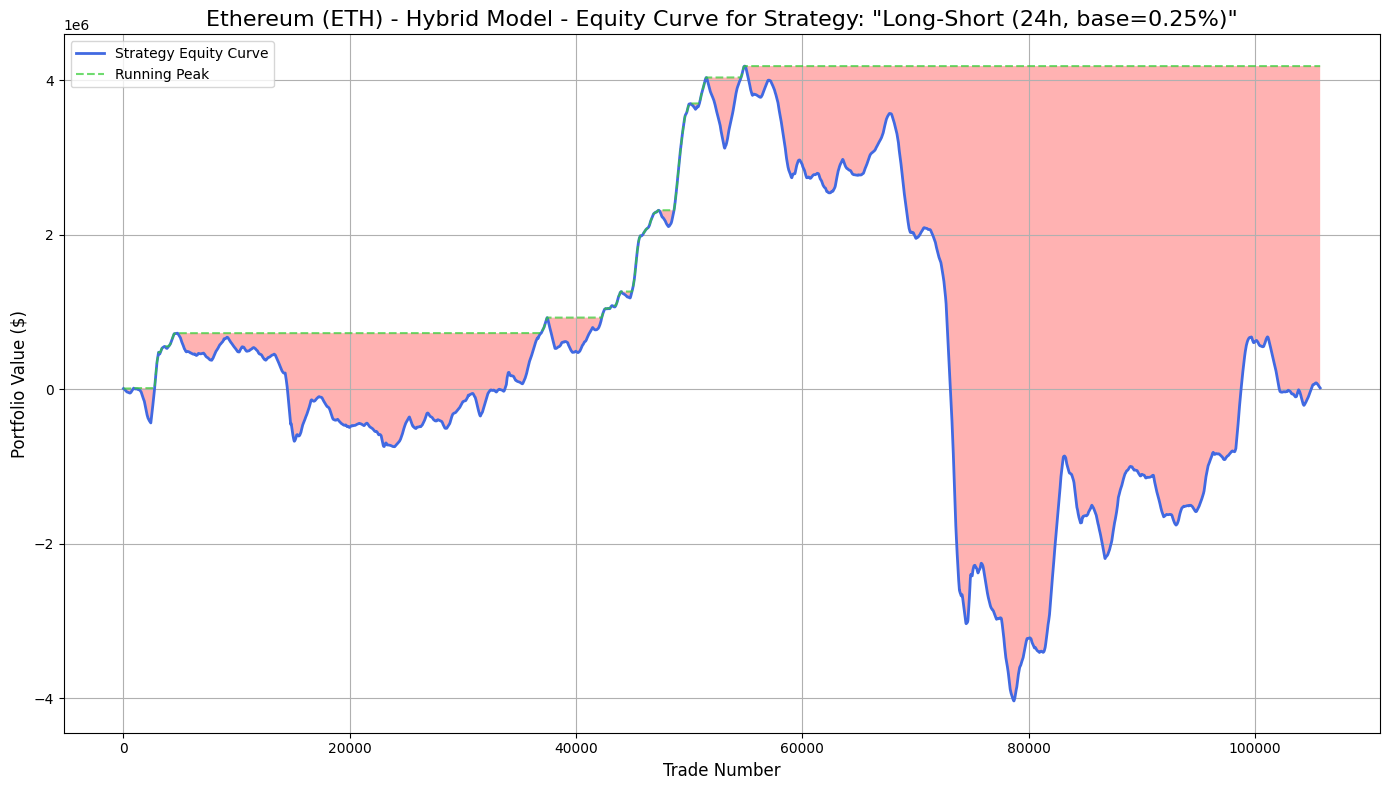


--- Running Backtest for Strategy: Long-Only (24h, base=0.5%) ---
Parameters: {'name': 'Long-Only (24h, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.5, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\239358030.py:103: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


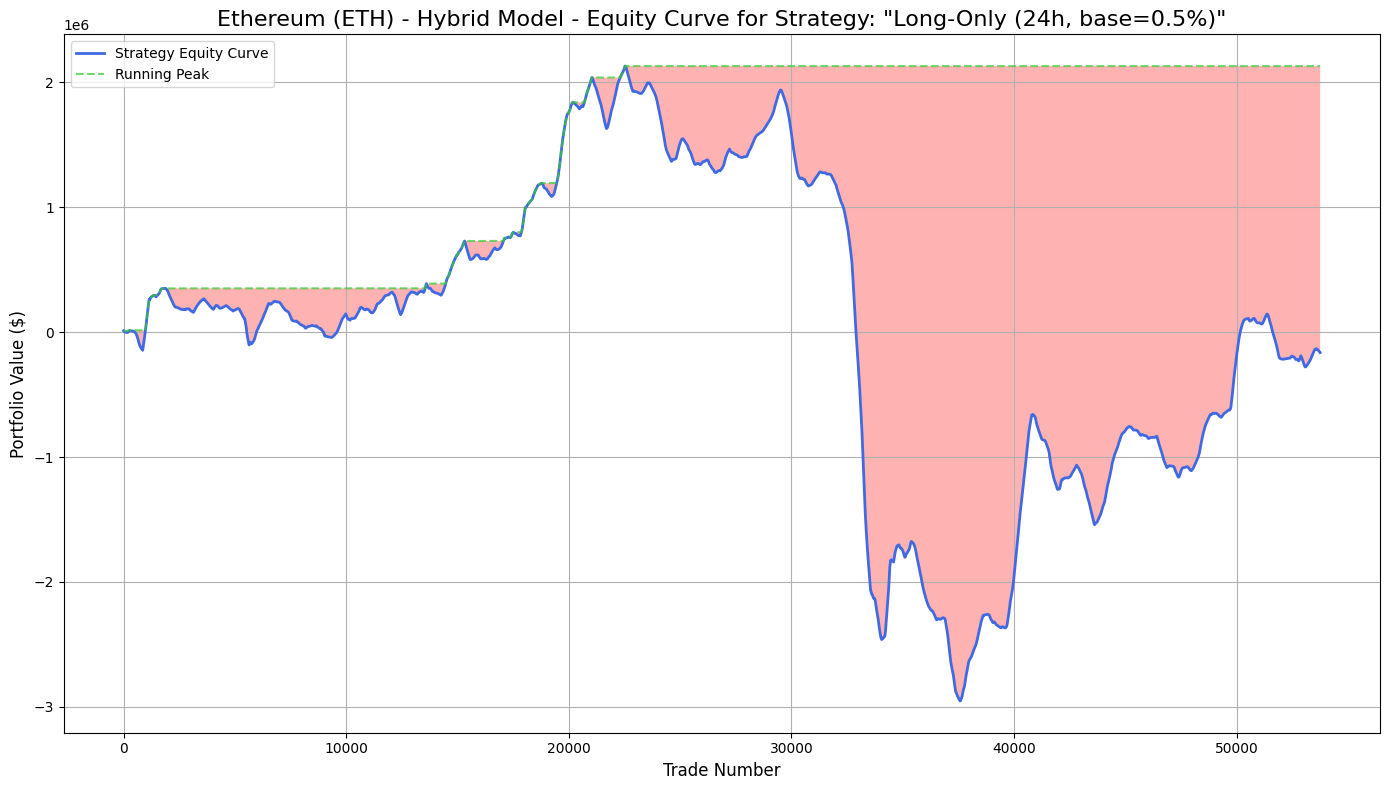


--- Running Backtest for Strategy: Long-Short (24h, base=0.5%) ---
Parameters: {'name': 'Long-Short (24h, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.5, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_27848\239358030.py:103: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


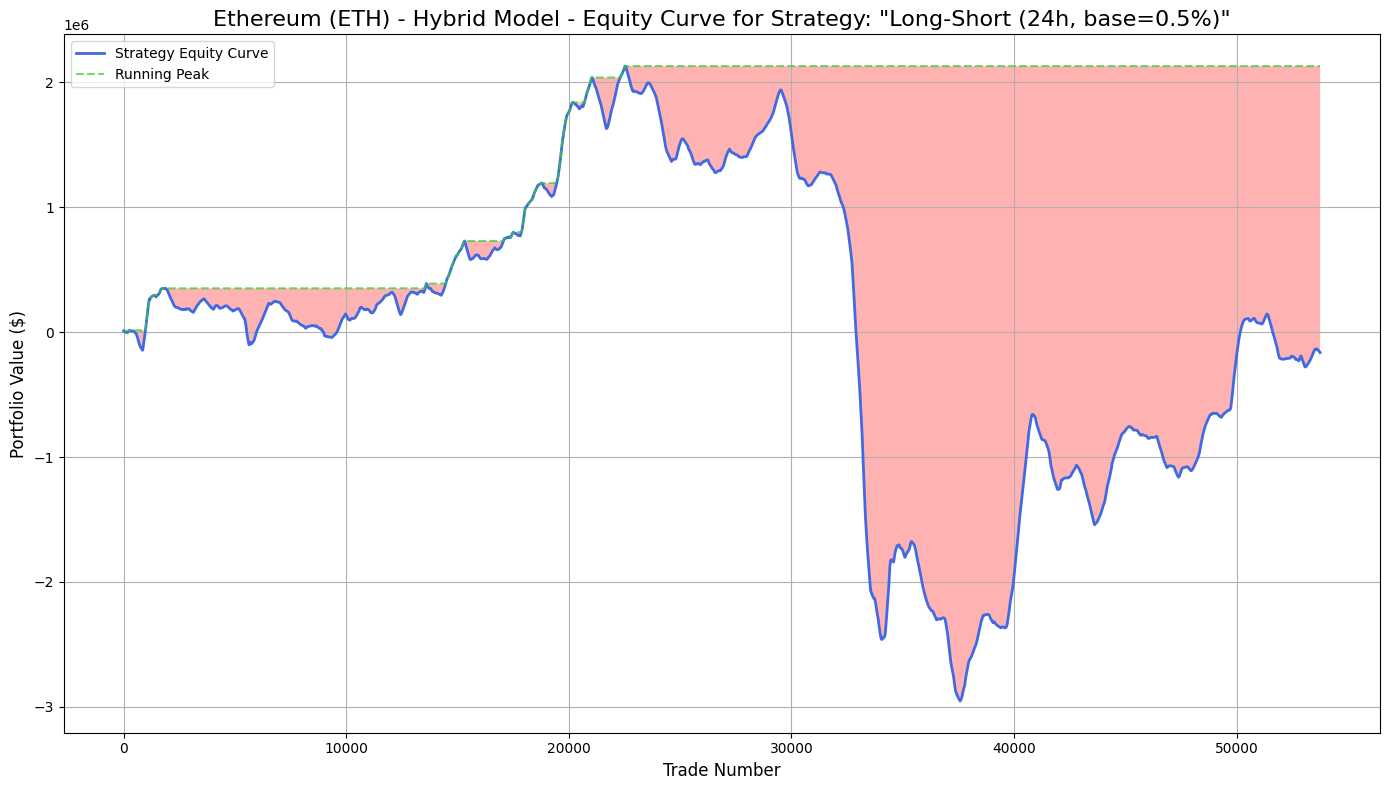


--- Running Backtest for Strategy: Long-Only (24h, base=1.0%) ---
Parameters: {'name': 'Long-Only (24h, base=1.0%)', 'type': 'long_only', 'trade_threshold': 1.0, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (24h, base=1.0%) ---
Parameters: {'name': 'Long-Short (24h, base=1.0%)', 'type': 'long_short', 'trade_threshold': 1.0, 'holding_period': 1440, 'prediction_target': 'Target_24h_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---


--- MASTER STRATEGY COMPARISON (ETHEREUM) ---
                              Total Return (%)  Buy & Hold (%)  Sharpe Ratio  \
Strategy                                                                       
Long-Only (5m, base=0.25%)             -124.15          -12.05         -1.14   
Long-Short (5m, base=0.25%)            -124

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- 1. Model Definition (Must match the trained model) ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out)
        out, _ = self.lstm2(out); out = self.dropout2(out)
        out = out[:, -1, :]; out = self.fc1(out)
        out = self.relu(out); out = self.fc2(out)
        return out

def run_backtest(asset_name, model_path, npz_path, raw_data_path, strategy_config):
    """
    A comprehensive backtesting function that simulates a given strategy and calculates advanced metrics.
    """
    strategy_name = strategy_config['name']
    print(f"\n{'='*30}\n--- Running Backtest for Strategy: {strategy_name} ---\n{'='*30}")
    print(f"Parameters: {strategy_config}")

    try:
        # --- Load Data & Model ---
        with np.load(npz_path, allow_pickle=True) as data:
            X_test, target_cols = data['X_test'], data['target_cols']
            X_test = X_test.astype(np.float32)

        raw_df = pd.read_csv(raw_data_path)
        # Handle Ethereum's specific format ('Unix Timestamp' in milliseconds)
        raw_df.rename(columns={'Unix Timestamp': 'Timestamp'}, inplace=True, errors='ignore')
        raw_df['Timestamp'] = pd.to_datetime(raw_df['Timestamp'] / 1000, unit='s')
        raw_df.sort_values('Timestamp', inplace=True)
        raw_df.reset_index(drop=True, inplace=True)
        
        required_len = len(X_test) + strategy_config['holding_period']
        test_prices_df = raw_df.tail(required_len).copy().reset_index(drop=True)
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = HybridLSTM(X_test.shape[2], 40, len(target_cols)).to(device)
        model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        model.eval()

        # --- Make Predictions ---
        test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=256)
        all_preds = [];
        with torch.no_grad():
            for batch_X_tuple in test_loader:
                preds = model(batch_X_tuple[0].to(device))
                all_preds.append(preds.cpu().numpy())
        predictions = np.concatenate(all_preds, axis=0)
            
        target_col_index = np.where(target_cols == strategy_config['prediction_target'])[0][0]
        final_predictions = predictions[:, target_col_index]

        # --- Simulate Trades (Unified Logic) ---
        print("Simulating trades with fixed holding period...")
        trades = []
        holding_period = strategy_config['holding_period']
        threshold = strategy_config['trade_threshold']
        
        for i in range(len(final_predictions)):
            if i + holding_period >= len(test_prices_df): break
            prediction = final_predictions[i]
            entry_price = test_prices_df['Close'].iloc[i]
            exit_price = test_prices_df['Close'].iloc[i + holding_period]

            if prediction > threshold:
                trades.append({"return_pct": ((exit_price - entry_price) / entry_price) * 100})
            elif strategy_config['type'] == 'long_short' and prediction < -threshold:
                trades.append({"return_pct": ((entry_price - exit_price) / entry_price) * 100})

        if not trades: print("\n--- No trades were triggered for this strategy. ---"); return None

        # --- Calculate Metrics ---
        trades_df = pd.DataFrame(trades)
        total_trades = len(trades_df); winning_trades_df = trades_df[trades_df['return_pct'] > 0]; win_rate = len(winning_trades_df) / total_trades * 100
        avg_return_per_trade = trades_df['return_pct'].mean(); avg_profit_on_winners = winning_trades_df['return_pct'].mean()
        initial_capital = 10000; returns_series = trades_df['return_pct'] / 100; pnl_series = returns_series * initial_capital
        equity_curve = pnl_series.cumsum() + initial_capital; final_capital = equity_curve.iloc[-1]
        strategy_total_return = (final_capital - initial_capital) / initial_capital * 100
        days_in_test_period = (test_prices_df['Timestamp'].iloc[-1] - test_prices_df['Timestamp'].iloc[0]).days
        if returns_series.std() != 0 and days_in_test_period > 0 and total_trades > 0:
            sharpe_ratio = returns_series.mean() / returns_series.std()
            annualization_factor = np.sqrt(365 * 24 * 60 / (days_in_test_period * 24 * 60 / total_trades))
            annualized_sharpe = sharpe_ratio * annualization_factor
        else: annualized_sharpe = 0
        peak = equity_curve.expanding(min_periods=1).max(); drawdown = (equity_curve - peak) / peak
        max_drawdown_pct = drawdown.min() * -100 if not drawdown.empty else 0
        years_in_test = days_in_test_period / 365.25 if days_in_test_period > 0 else 1
        annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return
        calmar_ratio = annualized_return / max_drawdown_pct if max_drawdown_pct > 0 else 0
        buy_hold_return = (test_prices_df['Close'].iloc[-1] - test_prices_df['Close'].iloc[0]) / test_prices_df['Close'].iloc[0] * 100
        
        # --- Plotting ---
        fig, ax = plt.subplots(figsize=(14, 8)); ax.plot(equity_curve.index, equity_curve, label='Strategy Equity Curve', color='royalblue', linewidth=2)
        ax.plot(peak.index, peak, label='Running Peak', color='limegreen', linestyle='--', alpha=0.7); ax.fill_between(drawdown.index, equity_curve, peak, where=equity_curve < peak, facecolor='red', alpha=0.3)
        ax.set_title(f'{asset_name} - Equity Curve for Strategy: "{strategy_name}"', fontsize=16); ax.set_xlabel('Trade Number', fontsize=12); ax.set_ylabel('Portfolio Value ($)', fontsize=12)
        ax.legend(loc='upper left'); ax.grid(True); plt.tight_layout(); plt.show()
        
        return {"Strategy": strategy_name, "Total Return (%)": strategy_total_return, "Buy & Hold (%)": buy_hold_return, "Sharpe Ratio": annualized_sharpe, "Calmar Ratio": calmar_ratio, "Max Drawdown (%)": max_drawdown_pct, "Win Rate (%)": win_rate, "Total Trades": total_trades}

    except Exception as e:
        print(f"An error occurred during backtest for '{strategy_name}': {e}")
        return None

def main():
    # --- Master Configuration for Ethereum ---
    master_config = {
        "asset_name": "Ethereum (ETH) - Hybrid Model",
        "model_path": "ethereum_hybrid_pytorch_model.pth",
        "npz_path": "ethereum_hybrid_pytorch_data.npz",
        "raw_data_path": "E:\\BAMD\\Ethereum\\ETH_1min.csv", # <-- IMPORTANT: Use your FULL raw ETH file
    }

    horizons = {
        "5m": {"holding_period": 5, "target_col": "Target_5m_Pct_Change"},
        "30m": {"holding_period": 30, "target_col": "Target_30m_Pct_Change"},
        "4h": {"holding_period": 240, "target_col": "Target_4h_Pct_Change"},
        "24h": {"holding_period": 1440, "target_col": "Target_24h_Pct_Change"},
    }
    base_thresholds = [0.25, 0.5, 1.0]
    strategy_types = ["long_only", "long_short"]

    all_strategies = []
    # --- Programmatically Generate All 24 Strategies ---
    for horizon_name, horizon_props in horizons.items():
        for base_thresh in base_thresholds:
            minutes_in_horizon = horizon_props["holding_period"]
            scaled_threshold = base_thresh * (minutes_in_horizon / 1440.0)

            for strat_type in strategy_types:
                strategy_name_human = f"{strat_type.replace('_','-').title()} ({horizon_name}, base={base_thresh}%)"
                all_strategies.append({
                    "name": strategy_name_human,
                    "type": strat_type,
                    "trade_threshold": scaled_threshold,
                    "holding_period": horizon_props["holding_period"],
                    "prediction_target": horizon_props["target_col"],
                })

    summary_results = []
    for strategy_config in all_strategies:
        result = run_backtest(**master_config, strategy_config=strategy_config)
        if result:
            summary_results.append(result)
    
    if summary_results:
        print("\n\n" + "="*40)
        print("--- MASTER STRATEGY COMPARISON (ETHEREUM) ---")
        print("="*40)
        summary_df = pd.DataFrame(summary_results).set_index("Strategy")
        pd.options.display.float_format = '{:,.2f}'.format
        print(summary_df)

if __name__ == "__main__":
    main()


--- Running Backtest for Strategy: Long-Only (5m, base=0.25%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_15912\784377414.py:37: RuntimeWarning: invalid value encountered in scalar power
  years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return


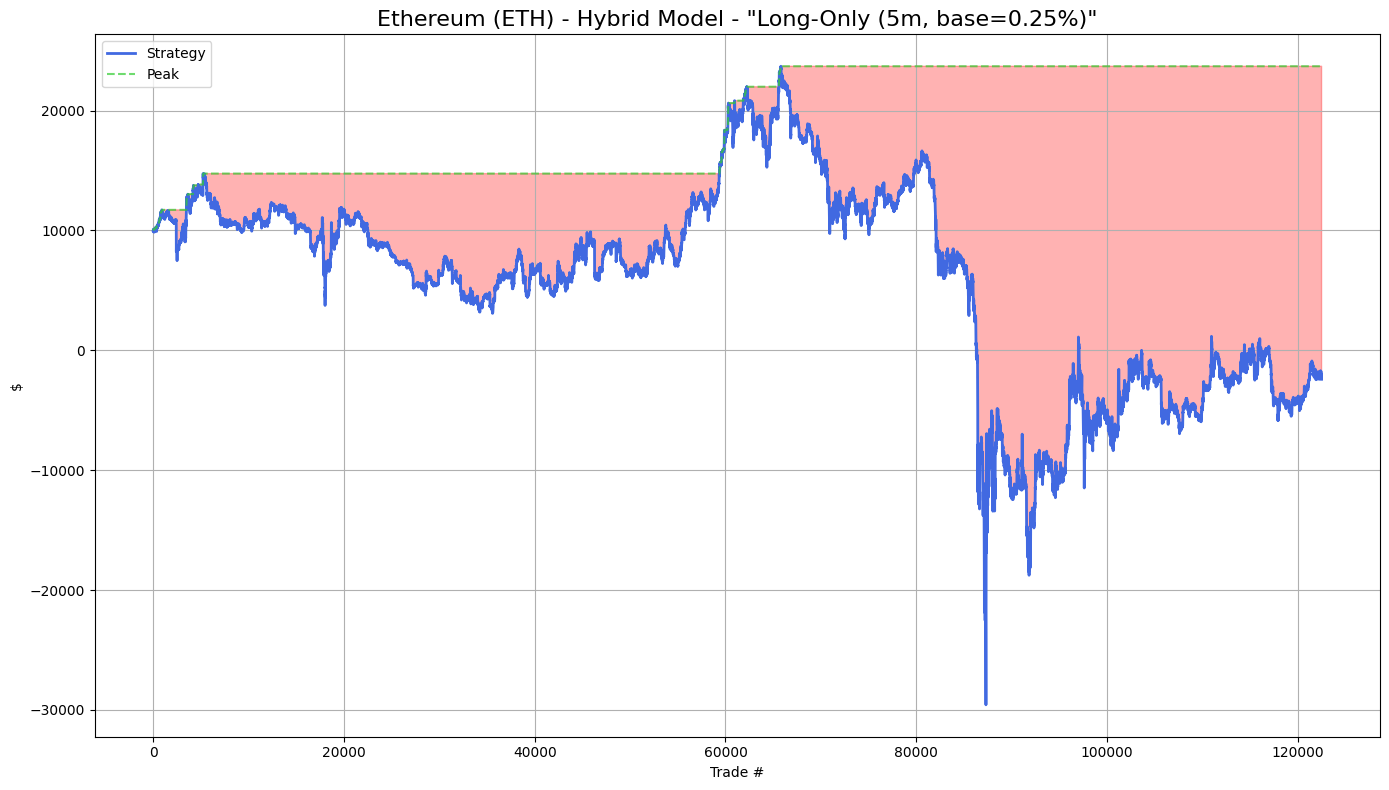


--- Running Backtest for Strategy: Long-Short (5m, base=0.25%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_15912\784377414.py:37: RuntimeWarning: invalid value encountered in scalar power
  years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return


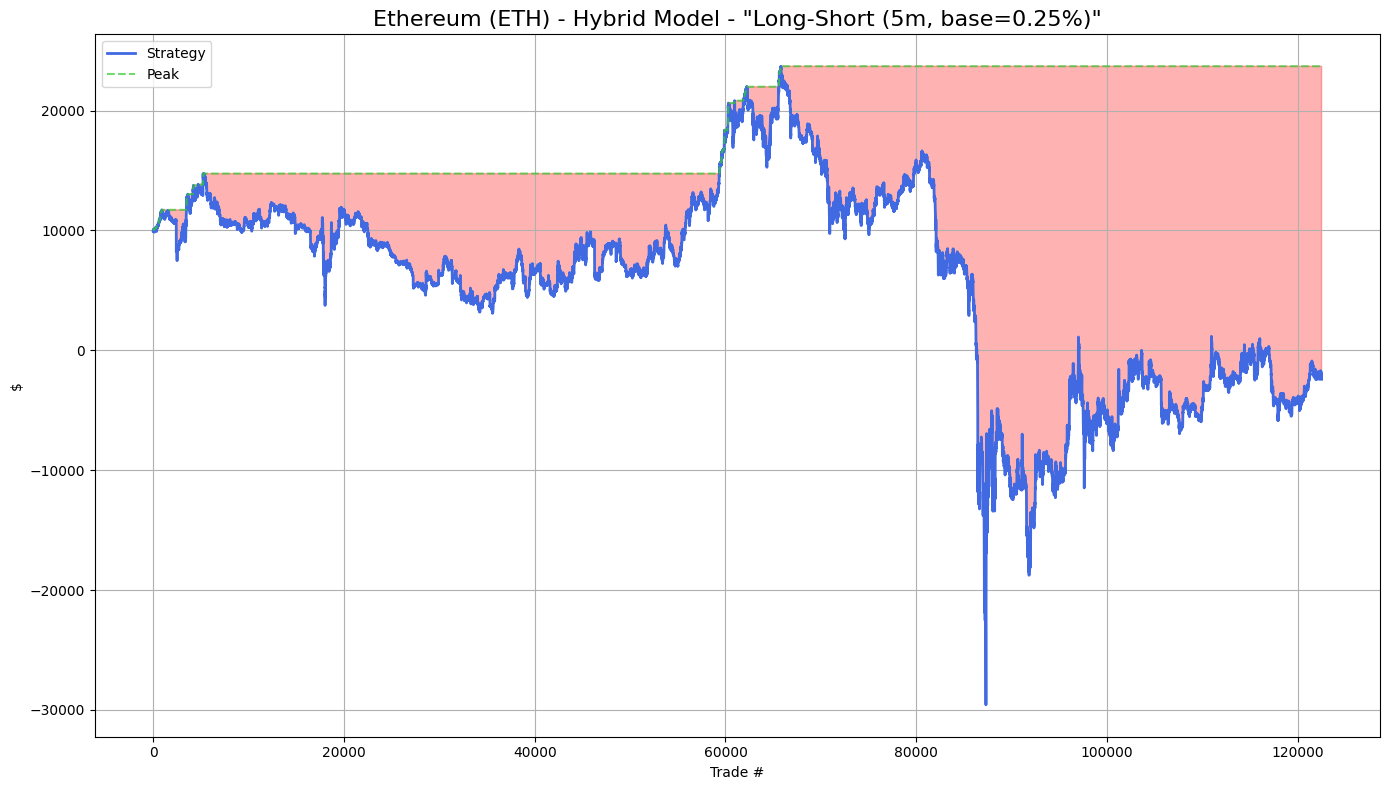


--- Running Backtest for Strategy: Long-Only (5m, base=0.5%) ---

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (5m, base=0.5%) ---

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Only (5m, base=1.0%) ---

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (5m, base=1.0%) ---

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Only (30m, base=0.25%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_15912\784377414.py:37: RuntimeWarning: invalid value encountered in scalar power
  years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return


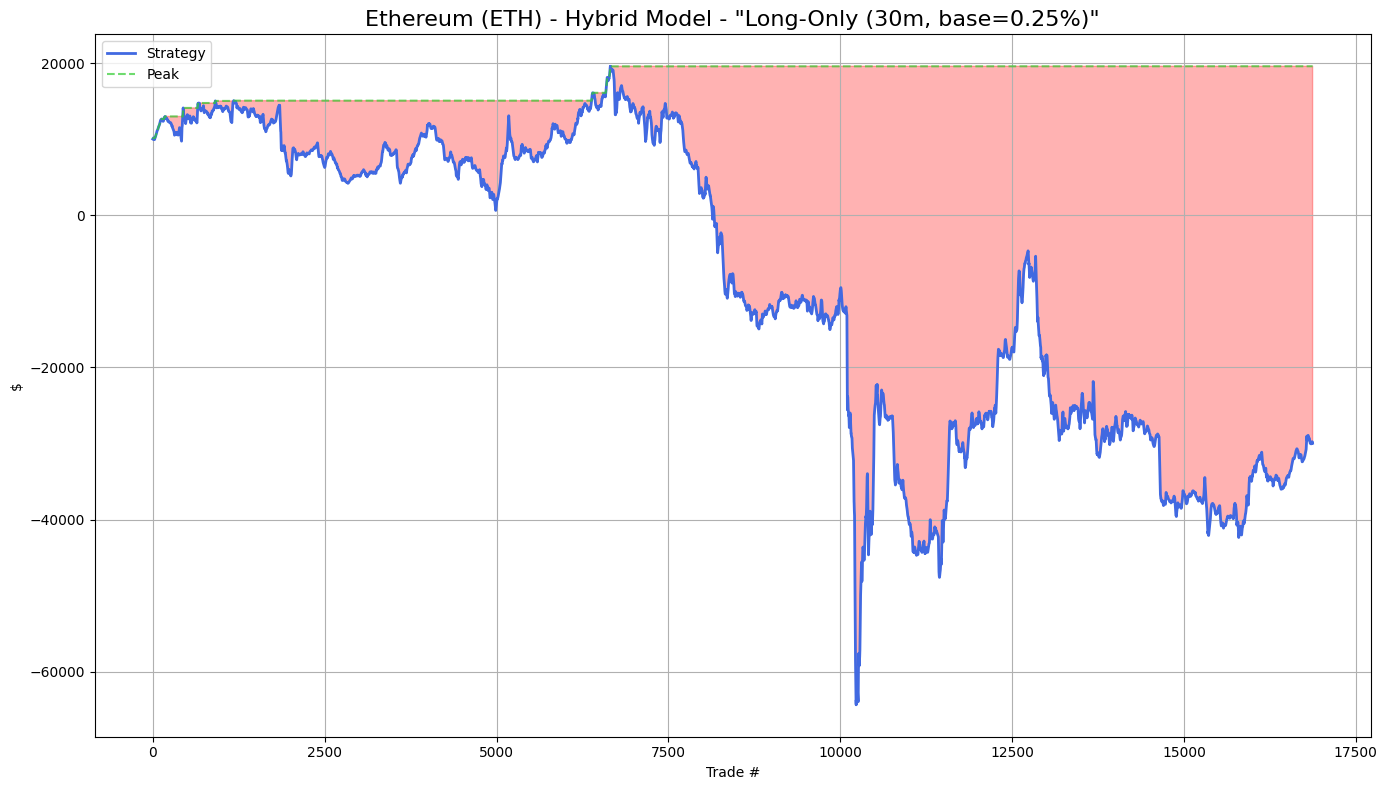


--- Running Backtest for Strategy: Long-Short (30m, base=0.25%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_15912\784377414.py:37: RuntimeWarning: invalid value encountered in scalar power
  years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return


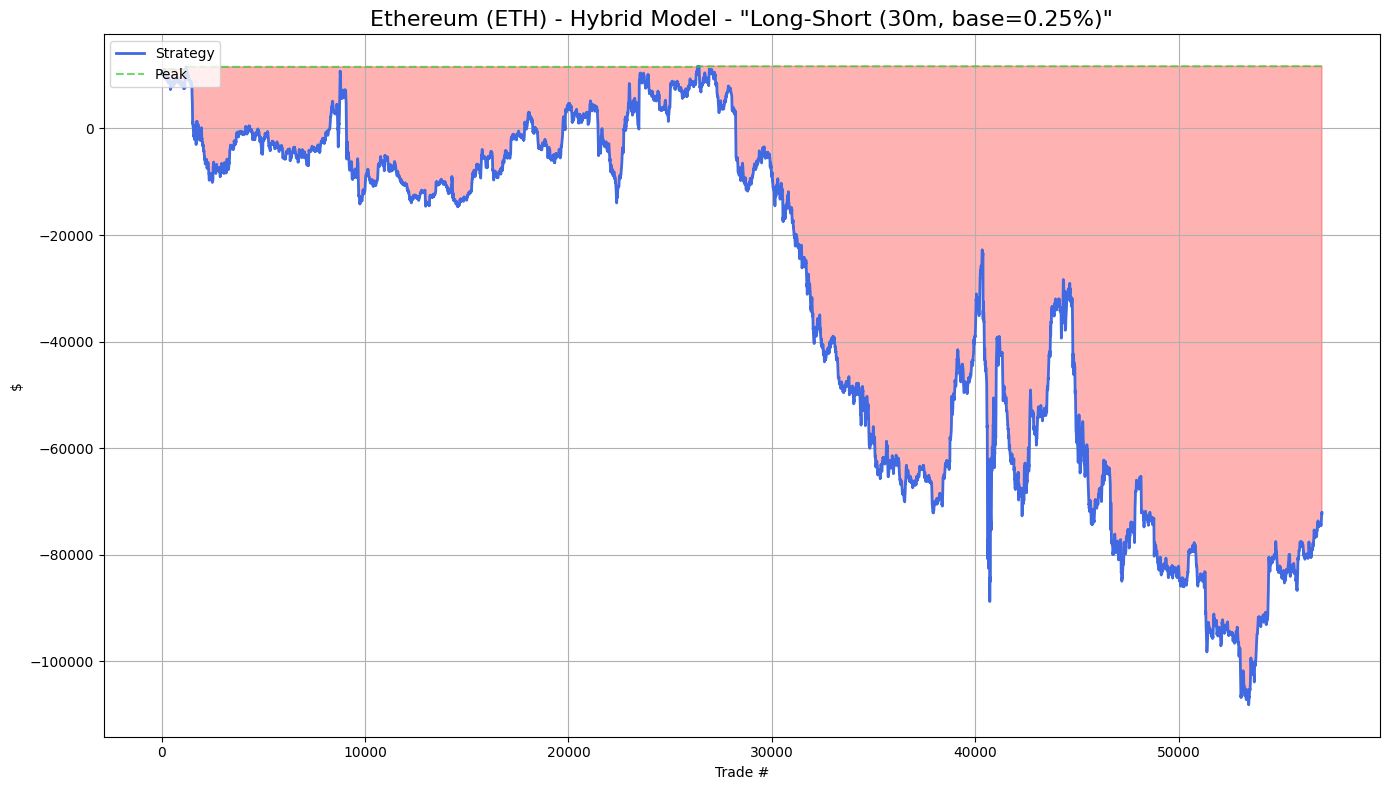


--- Running Backtest for Strategy: Long-Only (30m, base=0.5%) ---


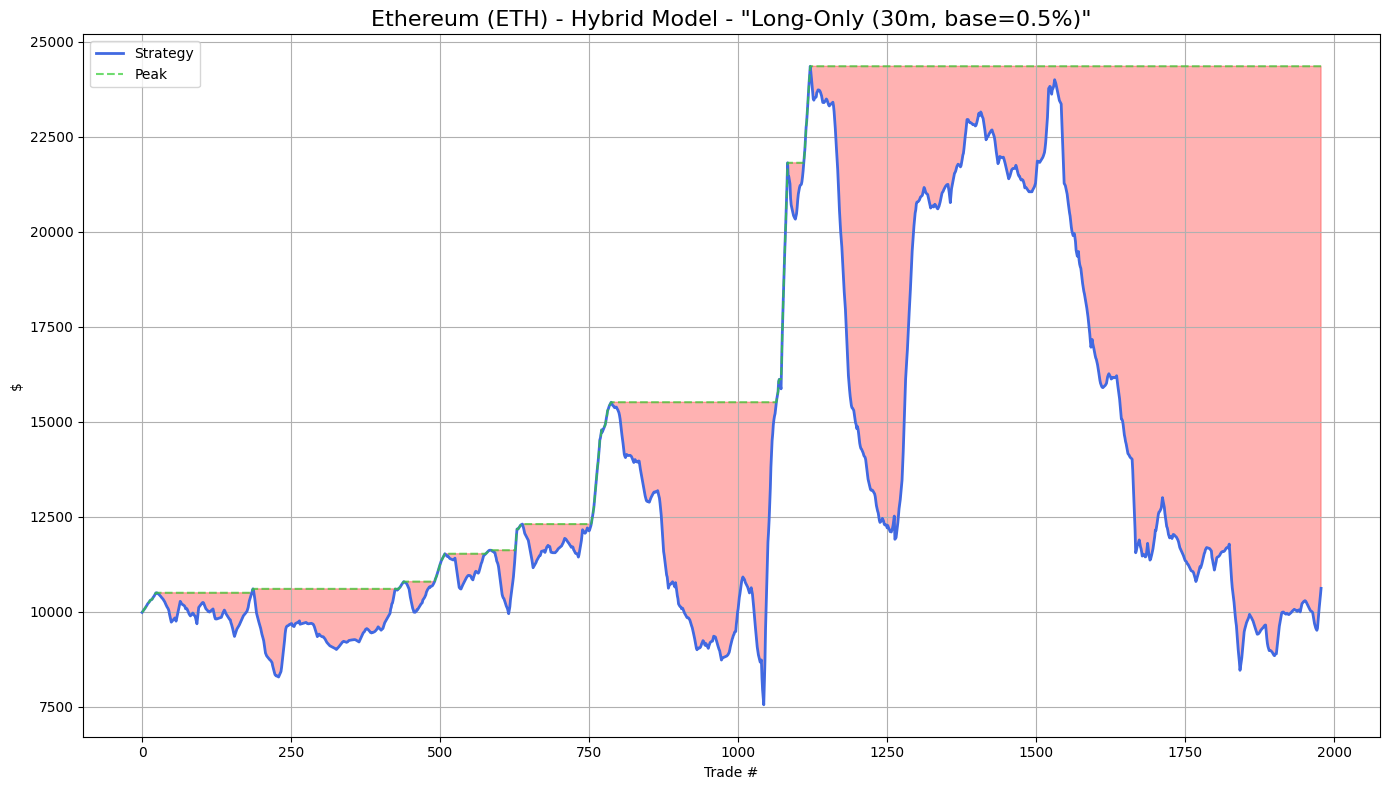


--- Running Backtest for Strategy: Long-Short (30m, base=0.5%) ---


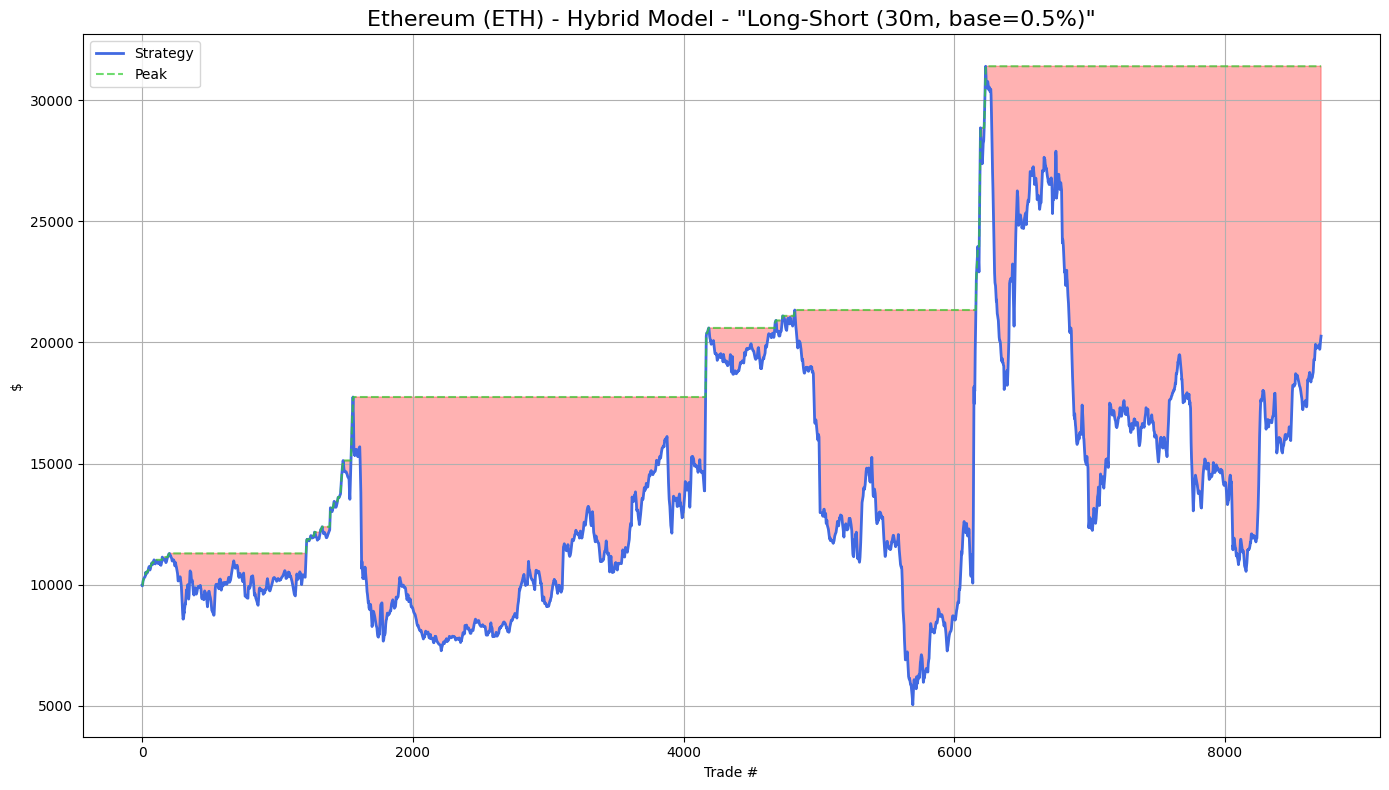


--- Running Backtest for Strategy: Long-Only (30m, base=1.0%) ---

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (30m, base=1.0%) ---

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Only (4h, base=0.25%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_15912\784377414.py:37: RuntimeWarning: invalid value encountered in scalar power
  years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return


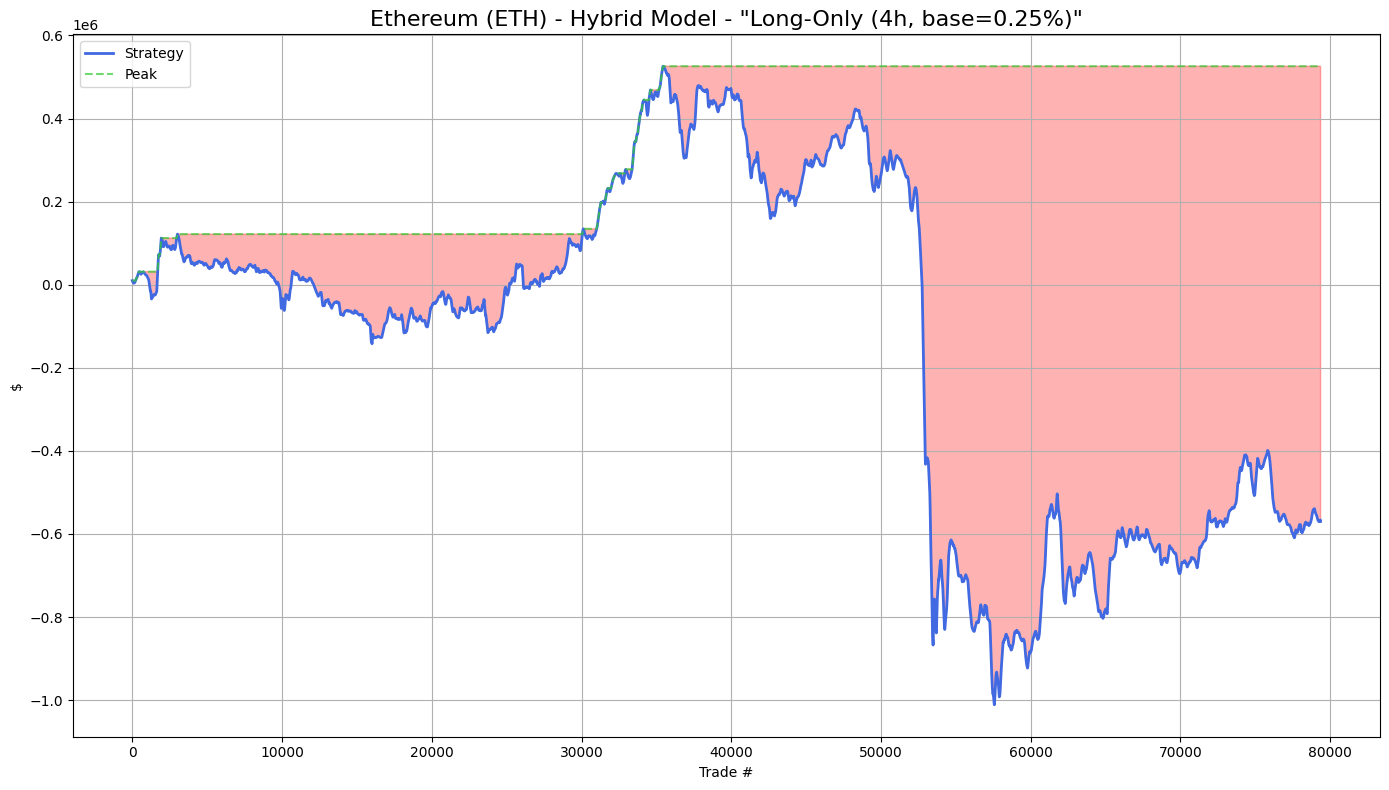


--- Running Backtest for Strategy: Long-Short (4h, base=0.25%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_15912\784377414.py:37: RuntimeWarning: invalid value encountered in scalar power
  years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return


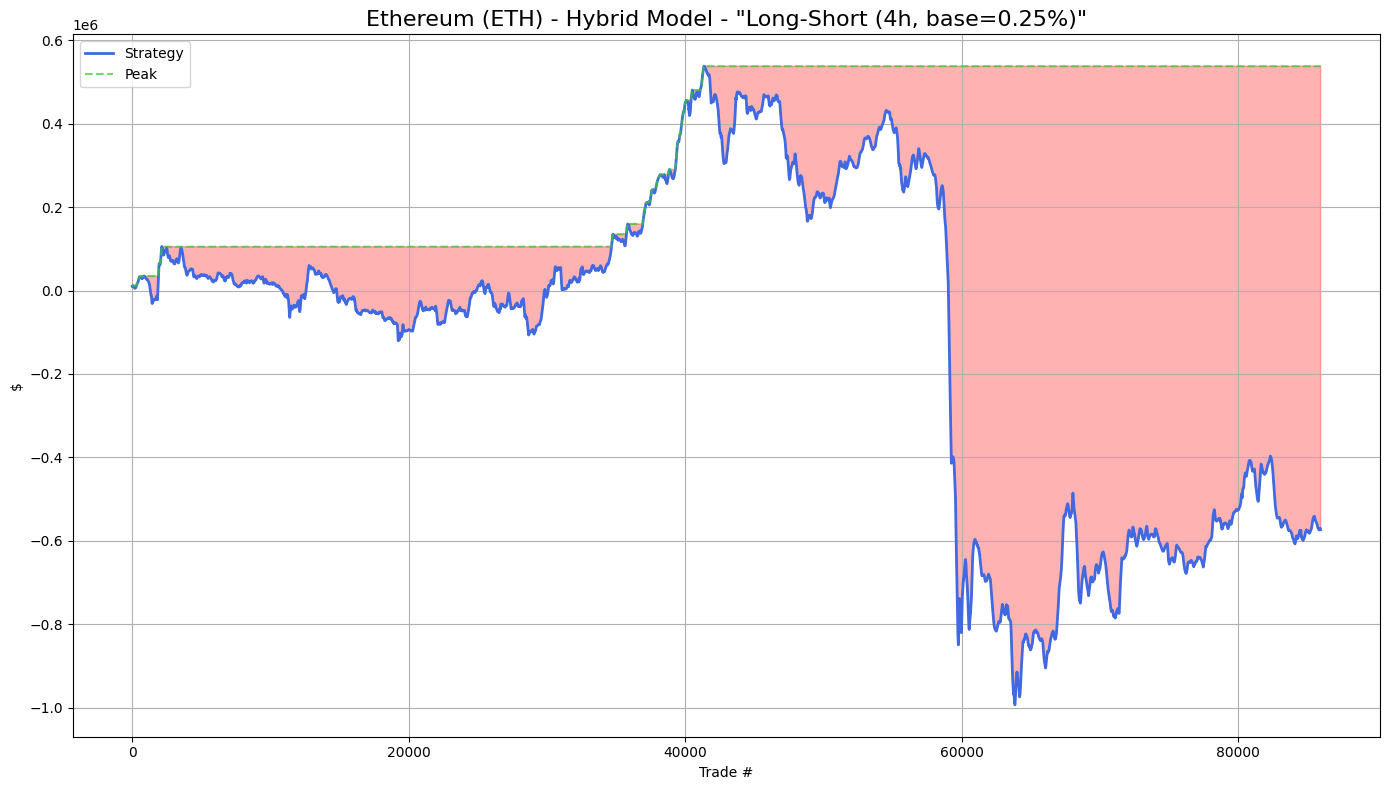


--- Running Backtest for Strategy: Long-Only (4h, base=0.5%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_15912\784377414.py:37: RuntimeWarning: invalid value encountered in scalar power
  years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return


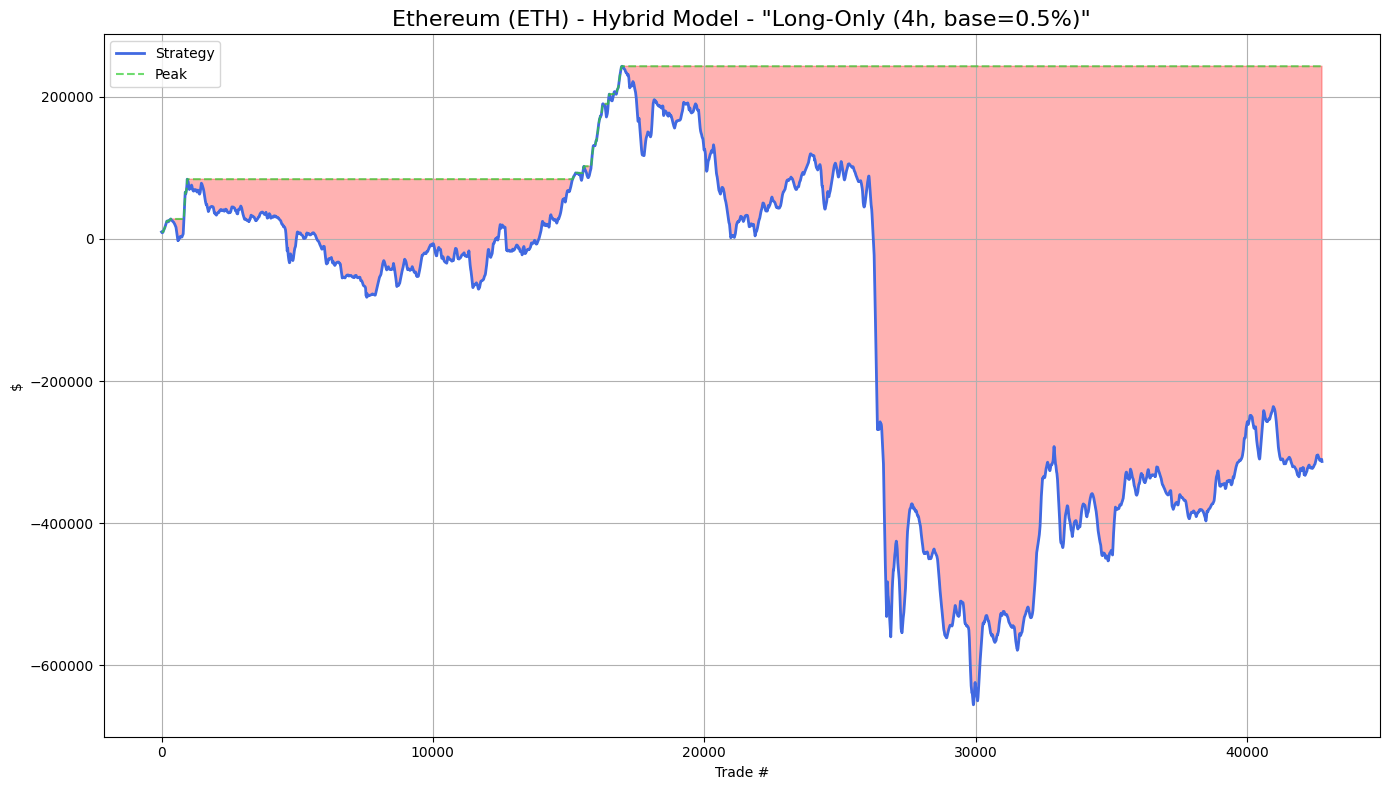


--- Running Backtest for Strategy: Long-Short (4h, base=0.5%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_15912\784377414.py:37: RuntimeWarning: invalid value encountered in scalar power
  years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return


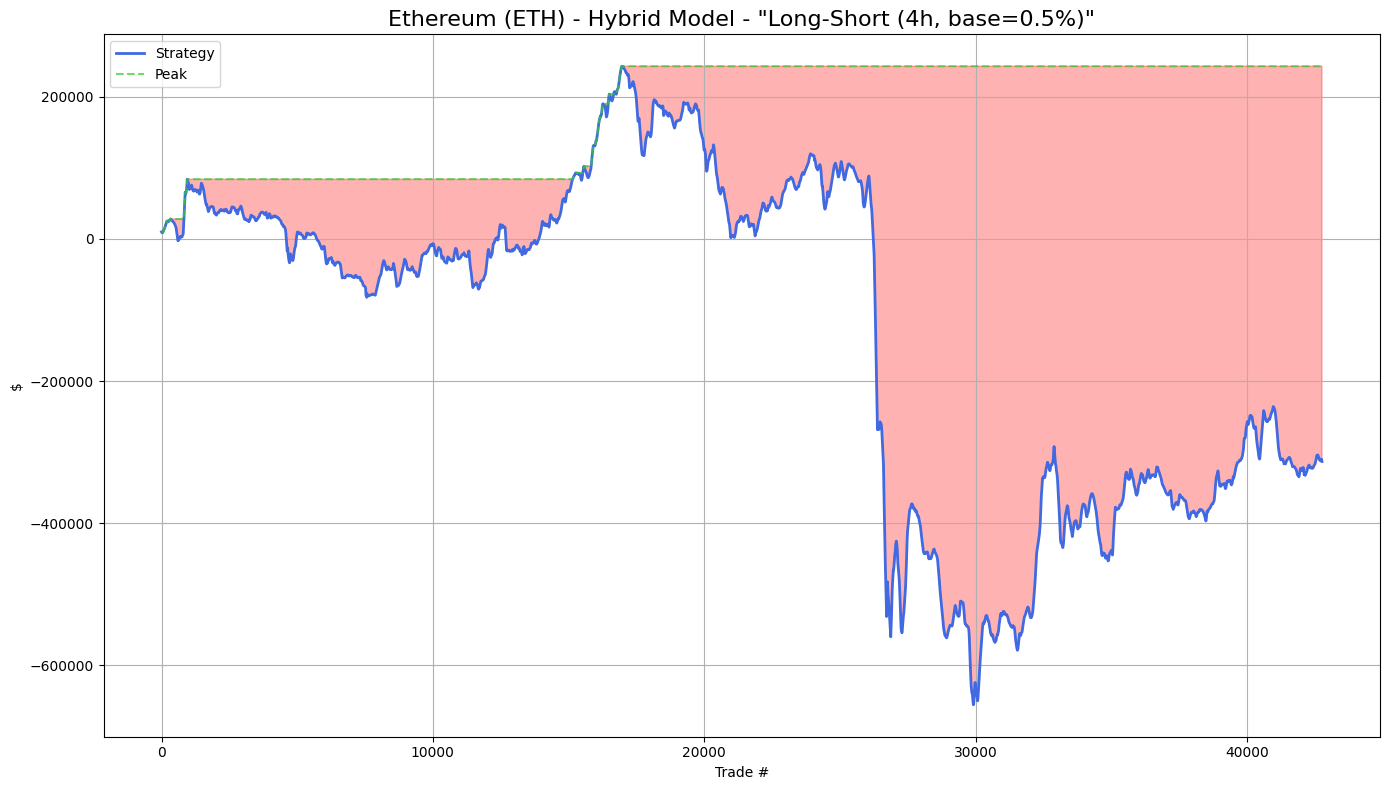


--- Running Backtest for Strategy: Long-Only (4h, base=1.0%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_15912\784377414.py:37: RuntimeWarning: invalid value encountered in scalar power
  years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return


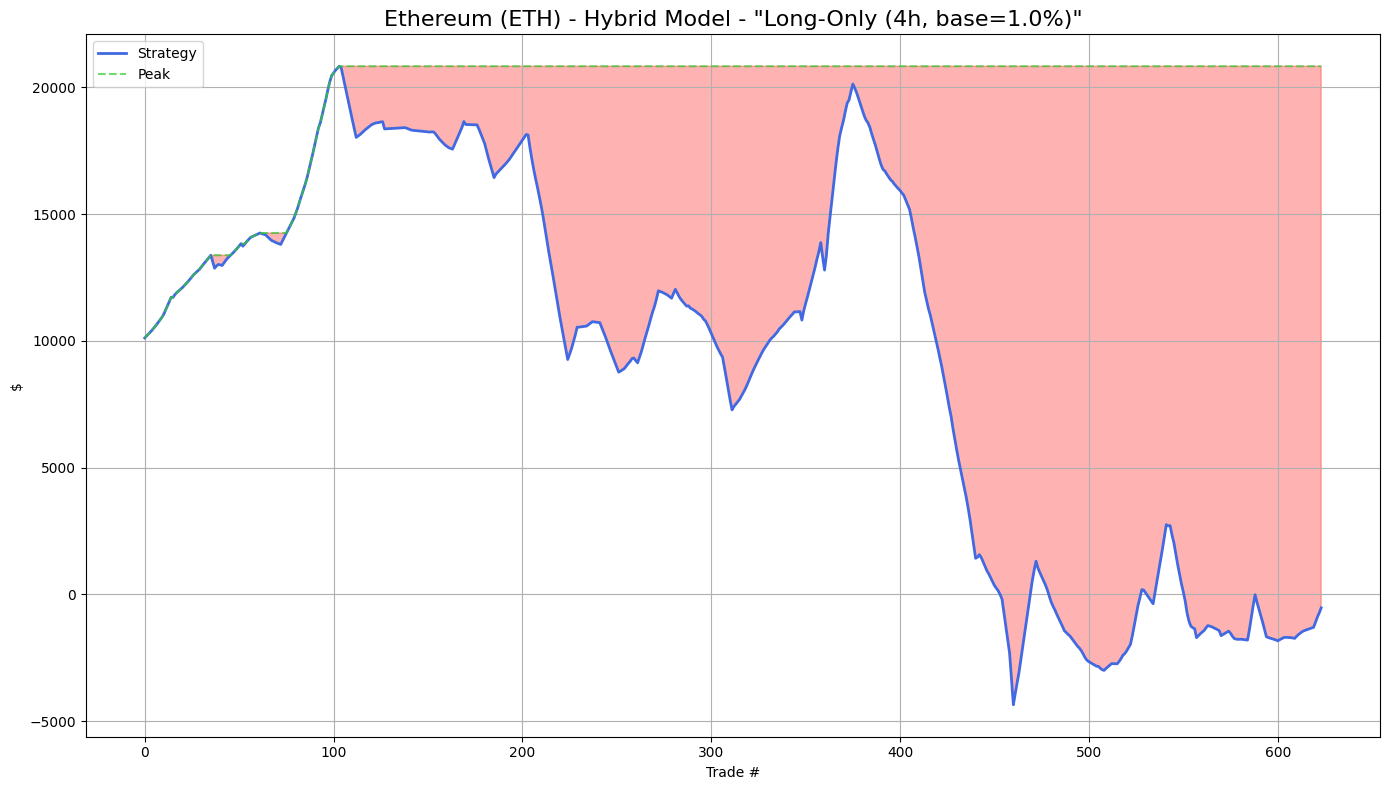


--- Running Backtest for Strategy: Long-Short (4h, base=1.0%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_15912\784377414.py:37: RuntimeWarning: invalid value encountered in scalar power
  years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return


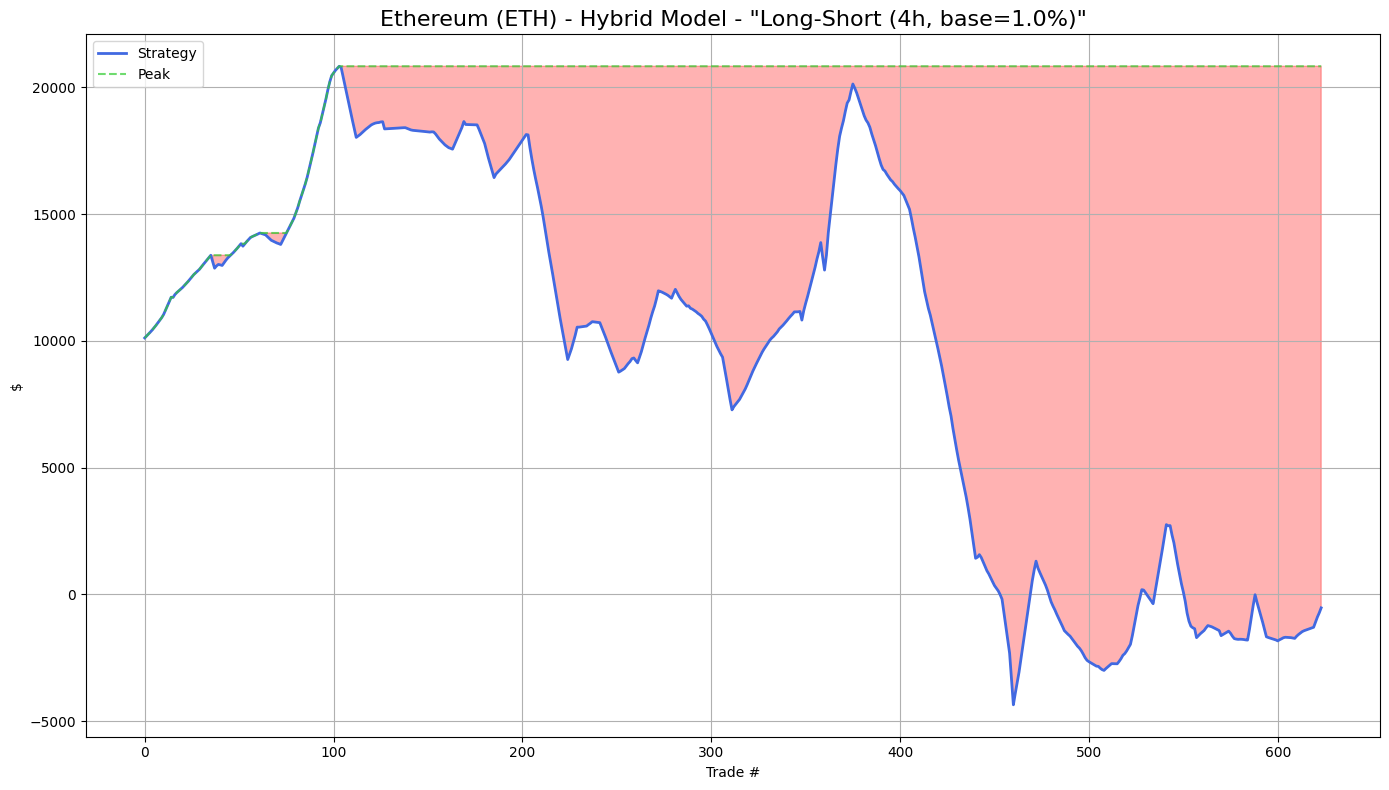


--- Running Backtest for Strategy: Long-Only (24h, base=0.25%) ---


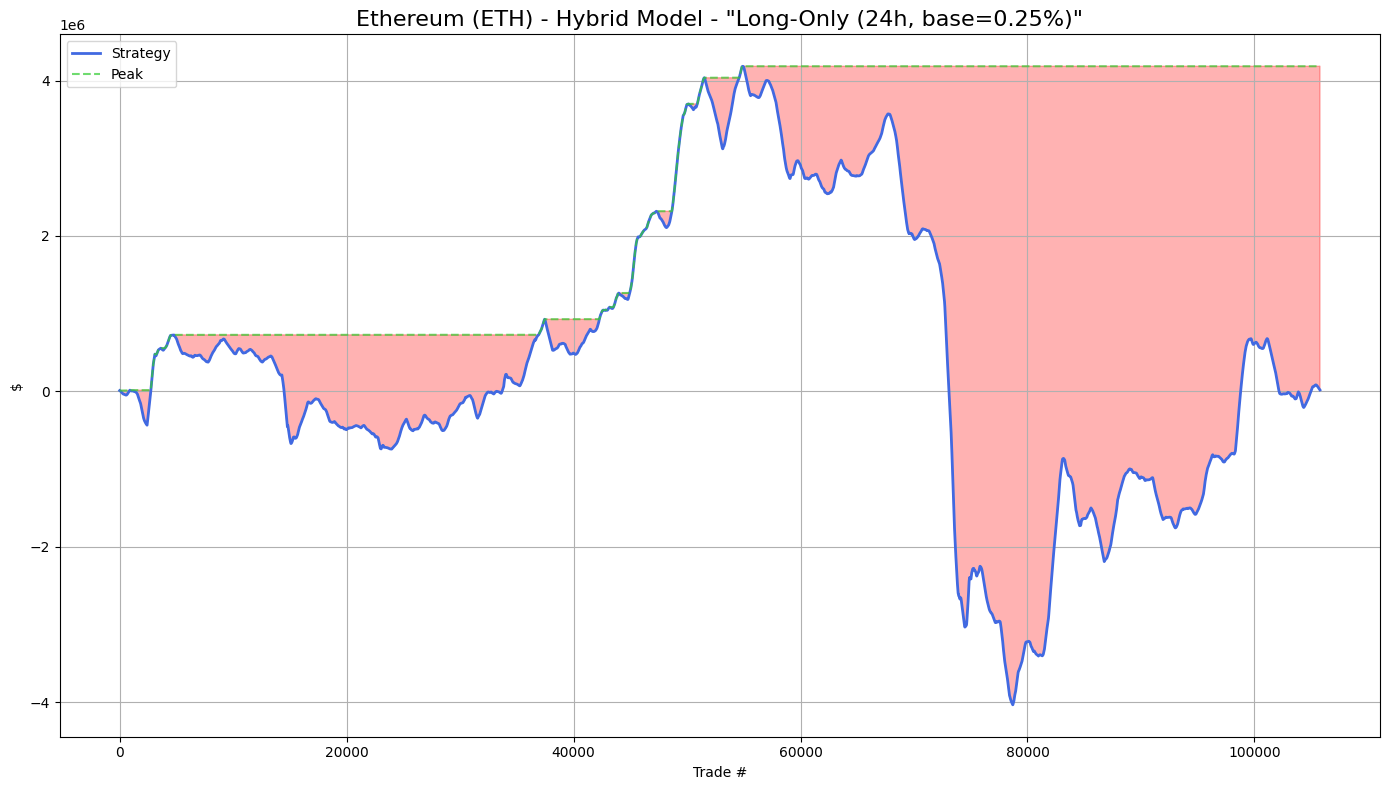


--- Running Backtest for Strategy: Long-Short (24h, base=0.25%) ---


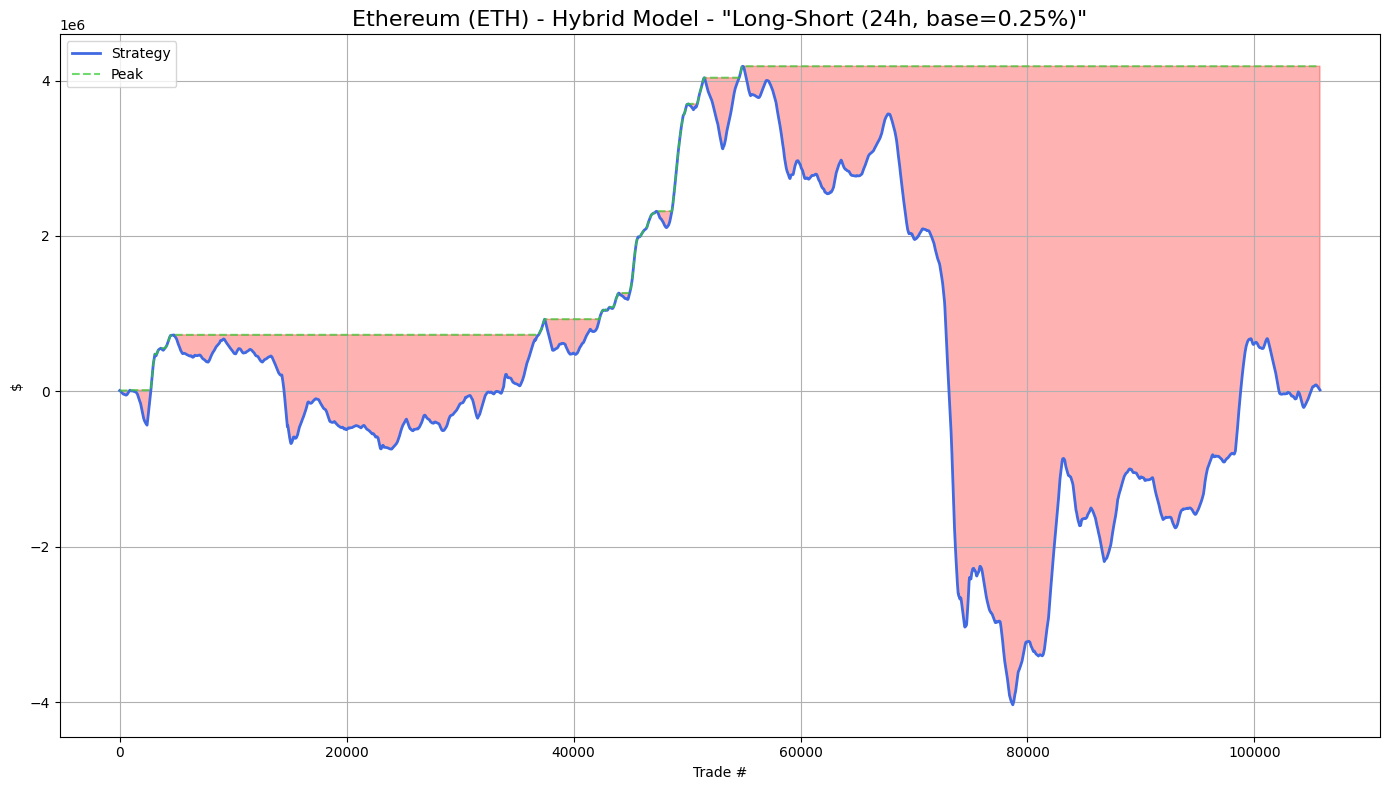


--- Running Backtest for Strategy: Long-Only (24h, base=0.5%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_15912\784377414.py:37: RuntimeWarning: invalid value encountered in scalar power
  years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return


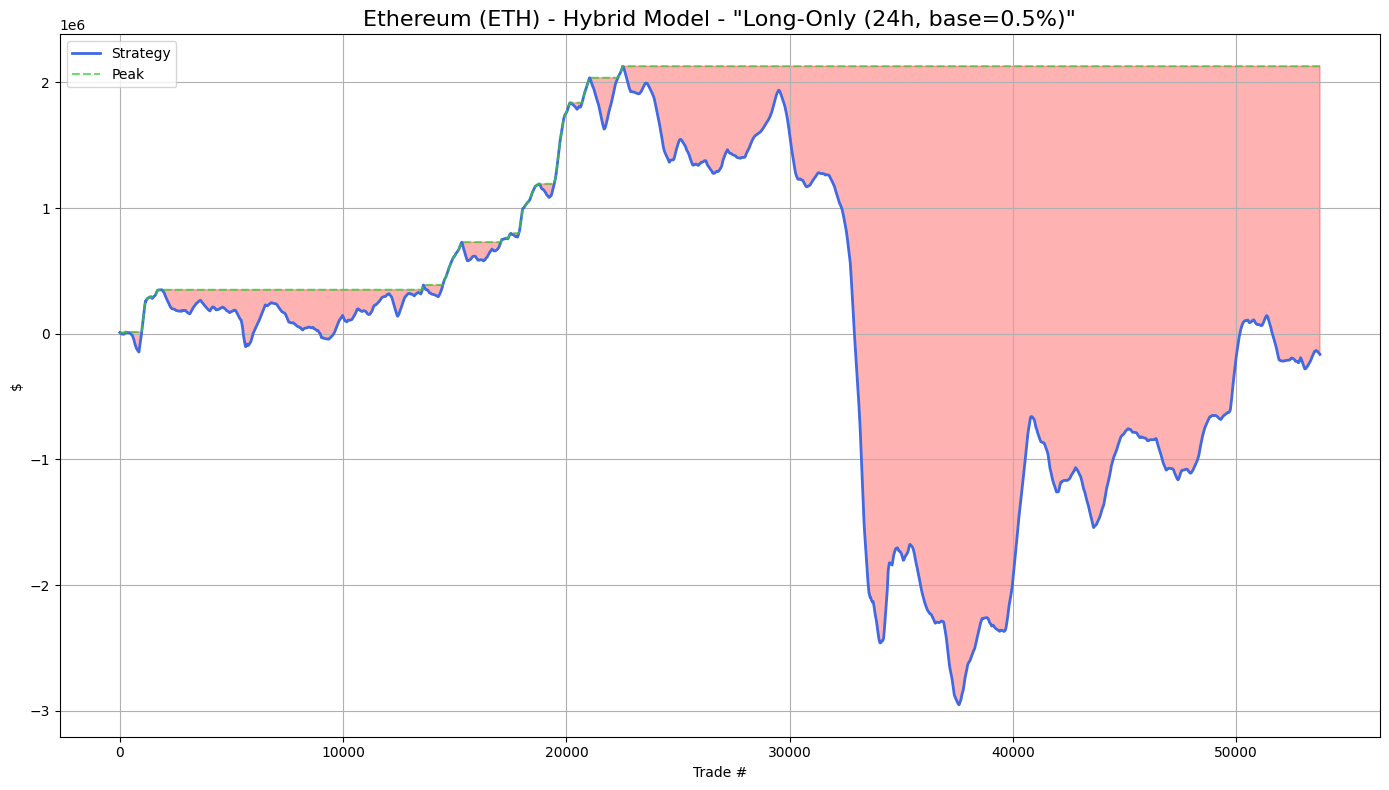


--- Running Backtest for Strategy: Long-Short (24h, base=0.5%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_15912\784377414.py:37: RuntimeWarning: invalid value encountered in scalar power
  years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return


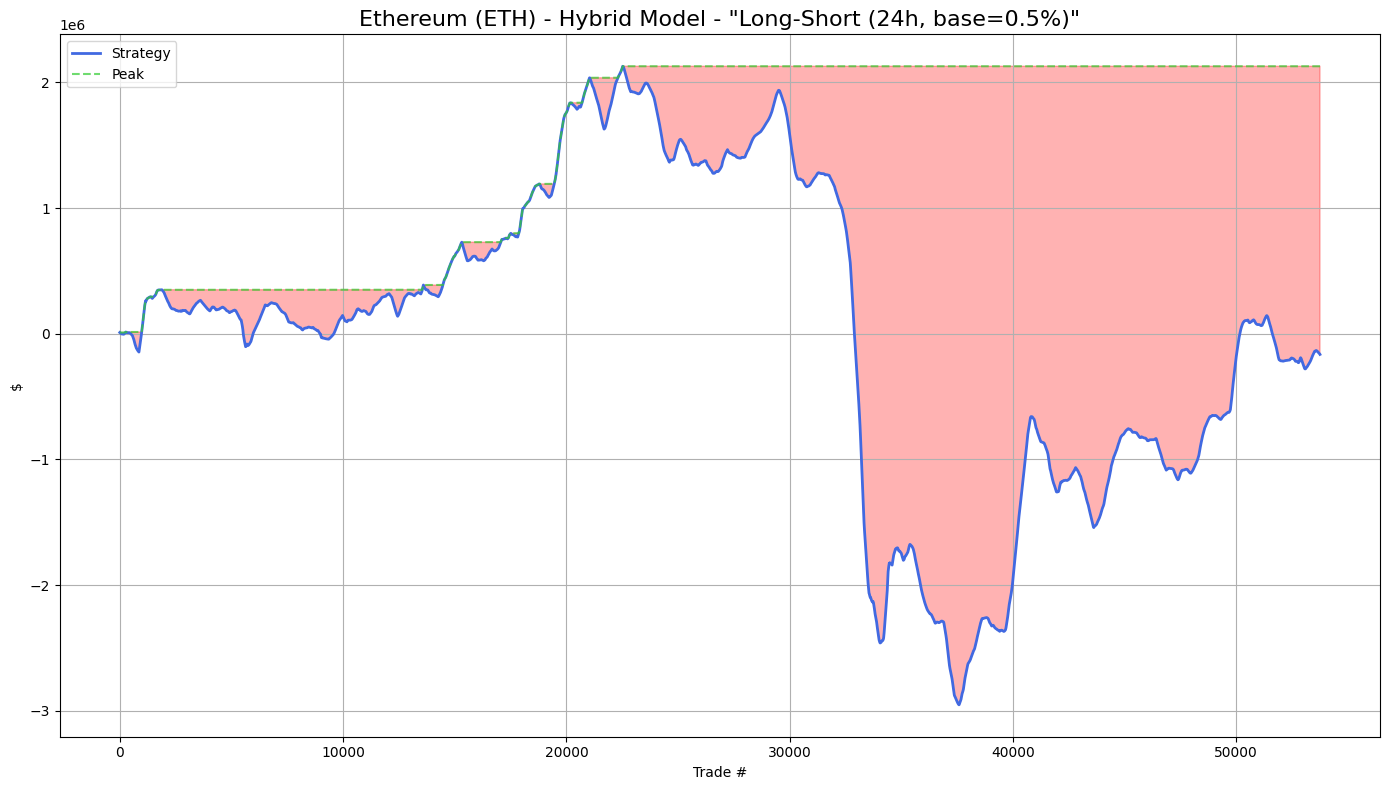


--- Running Backtest for Strategy: Long-Only (24h, base=1.0%) ---

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (24h, base=1.0%) ---

--- No trades were triggered. ---


--- MASTER STRATEGY COMPARISON (ETHEREUM) ---
                              Total Return (%)  Buy & Hold (%)  Sharpe Ratio  \
Strategy                                                                       
Long-Only (5m, base=0.25%)             -124.15          -12.05         -1.14   
Long-Short (5m, base=0.25%)            -124.15          -12.05         -1.14   
Long-Only (30m, base=0.25%)            -399.65          -12.19         -3.80   
Long-Short (30m, base=0.25%)           -822.05          -12.19         -5.08   
Long-Only (30m, base=0.5%)                6.14          -12.19          0.18   
Long-Short (30m, base=0.5%)             102.61          -12.19          1.82   
Long-Only (4h, base=0.25%)           -5,796.01          -12.83        -10.88   
Long-Short (4h, base=0.25%)

In [2]:
import pandas as pd; import numpy as np; import torch; import torch.nn as nn; from torch.utils.data import DataLoader, TensorDataset; import matplotlib.pyplot as plt
# --- The CORRECT Model Definition ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__(); self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True); self.dropout1 = nn.Dropout(0.2); self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True); self.dropout2 = nn.Dropout(0.2); self.fc1 = nn.Linear(in_features=hidden_units, out_features=25); self.relu = nn.ReLU(); self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)
    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out); out, _ = self.lstm2(out); out = self.dropout2(out); out = out[:, -1, :]; out = self.fc1(out); out = self.relu(out); out = self.fc2(out); return out
def run_backtest(asset_name, model_path, npz_path, raw_data_path, strategy_config):
    strategy_name = strategy_config['name']; print(f"\n{'='*30}\n--- Running Backtest for Strategy: {strategy_name} ---\n{'='*30}")
    try:
        with np.load(npz_path, allow_pickle=True) as data: X_test, target_cols = data['X_test'], data['target_cols']
        raw_df = pd.read_csv(raw_data_path); raw_df.rename(columns={'Unix Timestamp':'Timestamp'},inplace=True,errors='ignore'); raw_df['Timestamp']=pd.to_datetime(raw_df['Timestamp']/1000,unit='s'); raw_df.sort_values('Timestamp',inplace=True); raw_df.reset_index(drop=True,inplace=True)
        required_len=len(X_test)+strategy_config['holding_period']; test_prices_df=raw_df.tail(required_len).copy().reset_index(drop=True)
        device="cuda" if torch.cuda.is_available() else "cpu"; model=HybridLSTM(X_test.shape[2],40,len(target_cols)).to(device); model.load_state_dict(torch.load(model_path,map_location=torch.device(device))); model.eval()
        test_loader=DataLoader(TensorDataset(torch.from_numpy(X_test.astype(np.float32))),batch_size=256); all_preds=[]
        with torch.no_grad():
            for b in test_loader: p=model(b[0].to(device)); all_preds.append(p.cpu().numpy())
        predictions=np.concatenate(all_preds,axis=0); target_col_index=np.where(target_cols==strategy_config['prediction_target'])[0][0]; final_predictions=predictions[:,target_col_index]
        trades=[]
        if strategy_config['type']=='long_only':
            for i in range(len(final_predictions)):
                if i+strategy_config['holding_period']>=len(test_prices_df): break
                if final_predictions[i]>strategy_config['trade_threshold']: entry=test_prices_df['Close'].iloc[i]; exit_price=test_prices_df['Close'].iloc[i+strategy_config['holding_period']]; trades.append({"return_pct":((exit_price-entry)/entry)*100})
        elif strategy_config['type']=='long_short':
            for i in range(len(final_predictions)):
                if i+strategy_config['holding_period']>=len(test_prices_df): break
                prediction=final_predictions[i]; entry_price=test_prices_df['Close'].iloc[i]; exit_price=test_prices_df['Close'].iloc[i+strategy_config['holding_period']]
                if prediction>strategy_config['trade_threshold']: trades.append({"return_pct":((exit_price-entry_price)/entry_price)*100})
                elif prediction<-strategy_config['trade_threshold']: trades.append({"return_pct":((entry_price-exit_price)/entry_price)*100})
        if not trades: print("\n--- No trades were triggered. ---"); return None
        trades_df=pd.DataFrame(trades); total_trades=len(trades_df); win_df=trades_df[trades_df['return_pct']>0]; win_rate=len(win_df)/total_trades*100
        initial_capital=10000; returns_series=trades_df['return_pct']/100; pnl_series=returns_series*initial_capital; equity_curve=pnl_series.cumsum()+initial_capital
        final_capital=equity_curve.iloc[-1]; strategy_total_return=(final_capital-initial_capital)/initial_capital*100; days_in_test=(test_prices_df['Timestamp'].iloc[-1]-test_prices_df['Timestamp'].iloc[0]).days
        if returns_series.std()!=0 and days_in_test>0 and total_trades>0: sharp=returns_series.mean()/returns_series.std(); ann_factor=np.sqrt(365*24*60/(days_in_test*24*60/total_trades)); ann_sharp=sharp*ann_factor
        else: ann_sharp=0
        peak=equity_curve.expanding(min_periods=1).max(); drawdown=(equity_curve-peak)/peak; max_dd=drawdown.min()*-100 if not drawdown.empty else 0
        years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return
        calmar=ann_return/max_dd if max_dd>0 else 0; buy_hold=(test_prices_df['Close'].iloc[-1]-test_prices_df['Close'].iloc[0])/test_prices_df['Close'].iloc[0]*100
        fig,ax=plt.subplots(figsize=(14,8)); ax.plot(equity_curve.index,equity_curve,label='Strategy',color='royalblue',lw=2); ax.plot(peak.index,peak,label='Peak',color='limegreen',ls='--',alpha=0.7); ax.fill_between(drawdown.index,equity_curve,peak,where=equity_curve<peak,color='red',alpha=0.3)
        ax.set_title(f'{asset_name} - "{strategy_name}"',fontsize=16); ax.set_xlabel('Trade #'); ax.set_ylabel('$'); ax.legend(loc='upper left'); ax.grid(True); plt.tight_layout(); plt.show()
        return {"Strategy":strategy_name, "Total Return (%)":strategy_total_return, "Buy & Hold (%)":buy_hold, "Sharpe Ratio":ann_sharp, "Calmar Ratio":calmar, "Max Drawdown (%)":max_dd, "Win Rate (%)":win_rate, "Total Trades":total_trades}
    except Exception as e: print(f"Error for '{strategy_name}': {e}"); return None
def main():
    master_config = {"asset_name": "Ethereum (ETH) - Hybrid Model", "model_path": "ethereum_hybrid_pytorch_model.pth", "npz_path": "ethereum_hybrid_pytorch_data.npz", "raw_data_path": "E:\\BAMD\\Ethereum\\ETH_1min.csv"}
    horizons = {"5m": {"holding_period": 5, "target_col": "Target_5m_Pct_Change"}, "30m": {"holding_period": 30, "target_col": "Target_30m_Pct_Change"}, "4h": {"holding_period": 240, "target_col": "Target_4h_Pct_Change"}, "24h": {"holding_period": 1440, "target_col": "Target_24h_Pct_Change"}}
    base_thresholds = [0.25, 0.5, 1.0]; strategy_types = ["long_only", "long_short"]
    all_strategies = []
    for h_name, h_props in horizons.items():
        for b_thresh in base_thresholds:
            s_thresh = b_thresh * (h_props["holding_period"] / 1440.0)
            for s_type in strategy_types:
                name = f"{s_type.replace('_','-').title()} ({h_name}, base={b_thresh}%)"; all_strategies.append({"name":name, "type":s_type, "trade_threshold":s_thresh, "holding_period":h_props["holding_period"], "prediction_target":h_props["target_col"]})
    summary_results = [r for s_config in all_strategies if (r := run_backtest(**master_config, strategy_config=s_config)) is not None]
    if summary_results:
        print("\n\n" + "="*40); print("--- MASTER STRATEGY COMPARISON (ETHEREUM) ---"); print("="*40)
        summary_df = pd.DataFrame(summary_results).set_index("Strategy"); pd.options.display.float_format = '{:,.2f}'.format; print(summary_df)
        output_csv_filename = "ethereum_backtest_summary.csv"; summary_df.to_csv(output_csv_filename, float_format='%.2f'); print(f"\nSummary also saved to: {output_csv_filename}")
if __name__ == "__main__": main()